# Lower vaccination coverage against COVID-19 in school-aged children is associated with low socioeconomic status in the Metropolitan Area of Santiago, Chile.
## Enzo Guerrero-Araya, Cesar Ravello, Mario Rosemblatt & Tomas Perez-Acle

### Exploring the correlation between SES indices: all indices are correlated with SPI

In [1]:
import pandas as pd
from pathlib import Path
import datetime

fecha_ = '2022_05_26'
fecha = fecha_.replace('_','-')
json_dir = Path(f'vaccines_data/vacunacionescolar.mineduc.cl_{fecha_}/json')
json_dir.mkdir(parents=True, exist_ok=True)

def download_json_vac():
    directory = 'https://vacunacionescolar.mineduc.cl/json/'
    cli = f'wget -N --random-wait -r -p -e robots=off -U mozilla  {directory}'
    out = run(cli, shell=True, capture_output=True)
    return True

# download_json_vac()
# mineduc data in http://datos.mineduc.cl/dashboards/20015/DESCA-BASES-DE-DATOS-DIREC/
# COD_DEPE2: Código de Dependencia del Establecimiento (agrupado):
#     1: Municipal
#     2: Particular Subvencionado 
#     3: Particular Pagado
#     4: Corp. De Administración Delegada (DL 3166)
#     5: Servicio Local de Educación
# RURAL_RBD: Indicador de ruralidad
#     0: Urbano 
#     1:Rural
# ESTADO_ESTAB: Estado del establecimiento
#     1: Funcionando 
#     2: En receso 
#     3: Cerrado
#     4: Autorizado sin matrícula
# ORI_RELIGIOSA: Orientación Religiosa del Establecimiento
#     1: Orientación religiosa Laica
#     2: Orientación religiosa Católica 
#     3: Orientación religiosa Evangélica 
#     4: Orientación Musulmana
#     5: Orientación Judía
#     6: Orientación Budista
#     7: Orientación religiosa Otro 
#     9: Sin información
COD_DEPE2_tr = {
    1: 'Municipal',
    2: 'Particular Subvencionado',
    3: 'Particular Pagado',
    4: 'Corp. De Administración Delegada (DL 3166)',
    5: 'Servicio Local de Educación',
}
RURAL_RBD_tr = {
    0: 'Urbano',
    1: 'Rural ',
}
ESTADO_ESTAB_tr = {
    1: 'Funcionando',
    2: 'En receso ',
    3: 'Cerrado',
    4: 'Autorizado sin matrícula',
}
ORI_RELIGIOSA_tr = {
    1: 'Laica',
    2: 'Católica ',
    3: 'Evangélica',
    4: 'Musulmana',
    5: 'Judía',
    6: 'Budista',
    7: 'Otro',
    9: 'Sin información',
}
data_vac = list(json_dir.glob('*Establecimientos.json'))
vacunaciones = pd.read_json(data_vac[0])
for data in data_vac[1:]:
    #vacunaciones = vacunaciones.append(pd.read_json(data), ignore_index=True)
    vacunaciones = pd.concat([vacunaciones, pd.read_json(data)], ignore_index=True)
vacunaciones = vacunaciones.set_index('rbd')
update_time = datetime.datetime.fromtimestamp(data_vac[0].stat().st_mtime)
date = update_time.strftime('%Y-%m-%d')
# vacunaciones.index.unique()
# vacunaciones
mineduc = pd.read_csv('inputs/mineduc_data/20210927_Directorio_Oficial_EE_2021_20210430_WEB.csv', sep=';')
mineduc = mineduc.set_index('RBD')
mineduc['LATITUD'] = mineduc['LATITUD'].str.replace(',', '.')
mineduc['LONGITUD'] = mineduc['LONGITUD'].str.replace(',', '.')
mineduc["LATITUD"] = pd.to_numeric(mineduc["LATITUD"], errors='coerce')
mineduc["LONGITUD"] = pd.to_numeric(mineduc["LONGITUD"], errors='coerce')

mineduc["COD_DEPE2_mp"] = mineduc["COD_DEPE2"].map(COD_DEPE2_tr)
mineduc["RURAL_RBD_mp"] = mineduc["RURAL_RBD"].map(RURAL_RBD_tr)
cursos = ['Medio mayor', 'Prekínder', 'Kínder', '1° básico', '2° básico', '3° básico', '4° básico', '5° básico', '6° básico', '7° básico', '8° básico', '1° medio', '2° medio', '3° medio', '4° medio']

macroregion = {
    'Arica y Parinacota':'Northern',
    'Tarapacá':'Northern',
    'Antofagasta':'Northern',
    'Atacama':'Northern',
    'Coquimbo':'Center',
    'Valparaíso':'Center',
    "O'Higgins":'South Central',
    'Ñuble':'South Central',
    'Maule':'South Central',
    'Biobío':'South Central',
    'Araucanía':'Southern',
    'Los Ríos':'Southern',
    'Los Lagos':'Southern',
    'Aysén':'Austral',
    'Magallanes':'Austral',
    'Metropolitana':'Metropolitan',
}
idc = pd.read_csv('inputs/cut_idc_pvrty.csv', sep=',', index_col=0)
idc['Macroregion'] = idc['Region'].map(macroregion)
# idc
columns_to_merge = ['COD_DEPE2_mp', 'RURAL_RBD', 'ORI_RELIGIOSA', 'COD_COM_RBD', 'LATITUD', 'LONGITUD']
idcs = ['Municipality', 'Province', 'Region', 'Metropolitan_Area', 'Macroregion', 'Poverty', 'Multidimensional poverty', 'PHLBS', 'Health and social welfare', 'Economy and resources', 'Education', 'CDI', 'SVI', 'SPI']
# idcs = ['Municipality', 'CDI', 'SVI', 'SPI']
result = pd.merge(vacunaciones.reset_index(), mineduc[columns_to_merge], left_on = 'rbd', right_index = True, how = 'left')
result = pd.merge(result, idc[idcs], left_on = 'COD_COM_RBD', right_index = True, how = 'left')
result = result.drop(columns=['nom_region'])
result = result.loc[(result.Metropolitan_Area == 'Metropolitan_Area') & (result.nivel_alu.isin(cursos))]

# result
groupall = result.groupby(['COD_COM_RBD','Region', 'Province', 'Metropolitan_Area', 'Municipality', 'Macroregion'], as_index=False).median()

grupMetropolitanal = groupall.loc[groupall.Metropolitan_Area == 'Metropolitan_Area']
grupMetropolitanal = grupMetropolitanal.drop(columns=['rbd','porc_novacunados','RURAL_RBD','ORI_RELIGIOSA','porc_vacuincom','LATITUD','LONGITUD'])
grupMetropolitanal= grupMetropolitanal.rename({'COD_COM_RBD':'cod_comuna'}, axis=1)
vac_bins = [0, 80, 90, 100]
spi_bins = [0, 0.5, 0.7, 1]
grupMetropolitanal['vac_lab'] = pd.cut(grupMetropolitanal.porc_vacu, vac_bins, labels=[0,1,2])
grupMetropolitanal['CDI_lab'] = pd.cut(grupMetropolitanal.CDI, spi_bins, labels=[0,1,2])
grupMetropolitanal

cod_comuna         Region    Province  Metropolitan_Area  \
0      13101.0  Metropolitana    Santiago  Metropolitan_Area   
1      13102.0  Metropolitana    Santiago  Metropolitan_Area   
2      13103.0  Metropolitana    Santiago  Metropolitan_Area   
3      13104.0  Metropolitana    Santiago  Metropolitan_Area   
4      13105.0  Metropolitana    Santiago  Metropolitan_Area   
5      13106.0  Metropolitana    Santiago  Metropolitan_Area   
6      13107.0  Metropolitana    Santiago  Metropolitan_Area   
7      13108.0  Metropolitana    Santiago  Metropolitan_Area   
8      13109.0  Metropolitana    Santiago  Metropolitan_Area   
9      13110.0  Metropolitana    Santiago  Metropolitan_Area   
10     13111.0  Metropolitana    Santiago  Metropolitan_Area   
11     13112.0  Metropolitana    Santiago  Metropolitan_Area   
12     13113.0  Metropolitana    Santiago  Metropolitan_Area   
13     13114.0  Metropolitana    Santiago  Metropolitan_Area   
14     13115.0  Metropolitana    Santiago  Metropolitan_Area   
15     13116.0  Metropolitana    Santiago  Metropolitan_Area   
16     13117.0  Metropolitana    Santiago  Metropolitan_Area   
17     13118.0  Metropolitana    Santiago  Metropolitan_Area   
18     13119.0  Metropolitana    Santiago  Metropolitan_Area   
19     13120.0  Metropolitana    Santiago  Metropolitan_Area   
20     13121.0  Metropolitana    Santiago  Metropolitan_Area   
21     13122.0  Metropolitana    Santiago  Metropolitan_Area   
22     13123.0  Metropolitana    Santiago  Metropolitan_Area   
23     13124.0  Metropolitana    Santiago  Metropolitan_Area   
24     13125.0  Metropolitana    Santiago  Metropolitan_Area   
25     13126.0  Metropolitana    Santiago  Metropolitan_Area   
26     13127.0  Metropolitana    Santiago  Metropolitan_Area   
27     13128.0  Metropolitana    Santiago  Metropolitan_Area   
28     13129.0  Metropolitana    Santiago  Metropolitan_Area   
29     13130.0  Metropolitana    Santiago  Metropolitan_Area   
30     13131.0  Metropolitana    Santiago  Metropolitan_Area   
31     13132.0  Metropolitana    Santiago  Metropolitan_Area   
32     13201.0  Metropolitana  Cordillera  Metropolitan_Area   
33     13401.0  Metropolitana       Maipo  Metropolitan_Area   

           Municipality   Macroregion  porc_vacu  Poverty  \
0              Santiago  Metropolitan       89.0   0.0408   
1             Cerrillos  Metropolitan       82.5   0.0648   
2           Cerro Navia  Metropolitan       78.0   0.0759   
3              Conchalí  Metropolitan       82.0   0.0743   
4             El Bosque  Metropolitan       84.0   0.0958   
5      Estación Central  Metropolitan       84.0   0.0581   
6            Huechuraba  Metropolitan       88.5   0.0564   
7         Independencia  Metropolitan       86.0   0.0850   
8           La Cisterna  Metropolitan       85.0   0.0660   
9            La Florida  Metropolitan       86.0   0.0450   
10            La Granja  Metropolitan       83.0   0.0475   
11           La Pintana  Metropolitan       78.0   0.1414   
12             La Reina  Metropolitan       89.0   0.0099   
13           Las Condes  Metropolitan       92.0   0.0019   
14         Lo Barnechea  Metropolitan       90.0   0.0284   
15            Lo Espejo  Metropolitan       73.5   0.0669   
16             Lo Prado  Metropolitan       80.5   0.0578   
17                Macul  Metropolitan       86.0   0.0745   
18                Maipú  Metropolitan       87.0   0.0257   
19                Ñuñoa  Metropolitan       90.0   0.0090   
20  Pedro Aguirre Cerda  Metropolitan       78.0   0.0621   
21            Peñalolén  Metropolitan       87.0   0.0437   
22          Providencia  Metropolitan       91.0   0.0043   
23             Pudahuel  Metropolitan       84.0   0.0825   
24            Quilicura  Metropolitan       86.0   0.0568   
25        Quinta Normal  Metropolitan       84.0   0.0373   
26             Recoleta  Metropolitan       85.0   0.0689   
27                Renca  Metropolitan       82.0   0.03

In [2]:
ALPHA = 0.01
bbox = dict(boxstyle="round", fc="1", alpha=0.5)
size = "small"
def corrfunc(x, y, pv=0.01, **kws):
    r, p = stats.pearsonr(x, y)
#     slope, intercept, r, p, std_err = stats.linregress(x,y)
    ax = plt.gca()
#     ax.annotate(f'r={r:.2f}, p<{pv}',
#                 xy=(.1, .9), xycoords=ax.transAxes)
    if p < pv:
        ax.annotate(f'r={r:.2f}, p<{pv}',
                    xy=(.05, .90), xycoords=ax.transAxes, bbox=bbox, fontsize=size)
    else:
        ax.annotate(f'r={r:.2f}, p={p:.2g}',
                    xy=(.05, .90), xycoords=ax.transAxes, bbox=bbox, fontsize=size)
def spearmanrfunc(x, y, pv=0.01, **kws):
    r, p = stats.spearmanr(x, y)
#     slope, intercept, r, p, std_err = stats.linregress(x,y)
    ax = plt.gca()
#     ax.annotate(f'r={r:.2f}, p<{pv}',
#                 xy=(.1, .9), xycoords=ax.transAxes)
    if p < pv:
        ax.annotate(f'ρ={r:.2f}, p<{pv}',
                    xy=(.05, .90), xycoords=ax.transAxes, bbox=bbox, fontsize=size)
    else:
        ax.annotate(f'ρ={r:.2f}, p={p:.2g}',
                    xy=(.05, .90), xycoords=ax.transAxes, bbox=bbox, fontsize=size)


#### Supplementary Figure 1

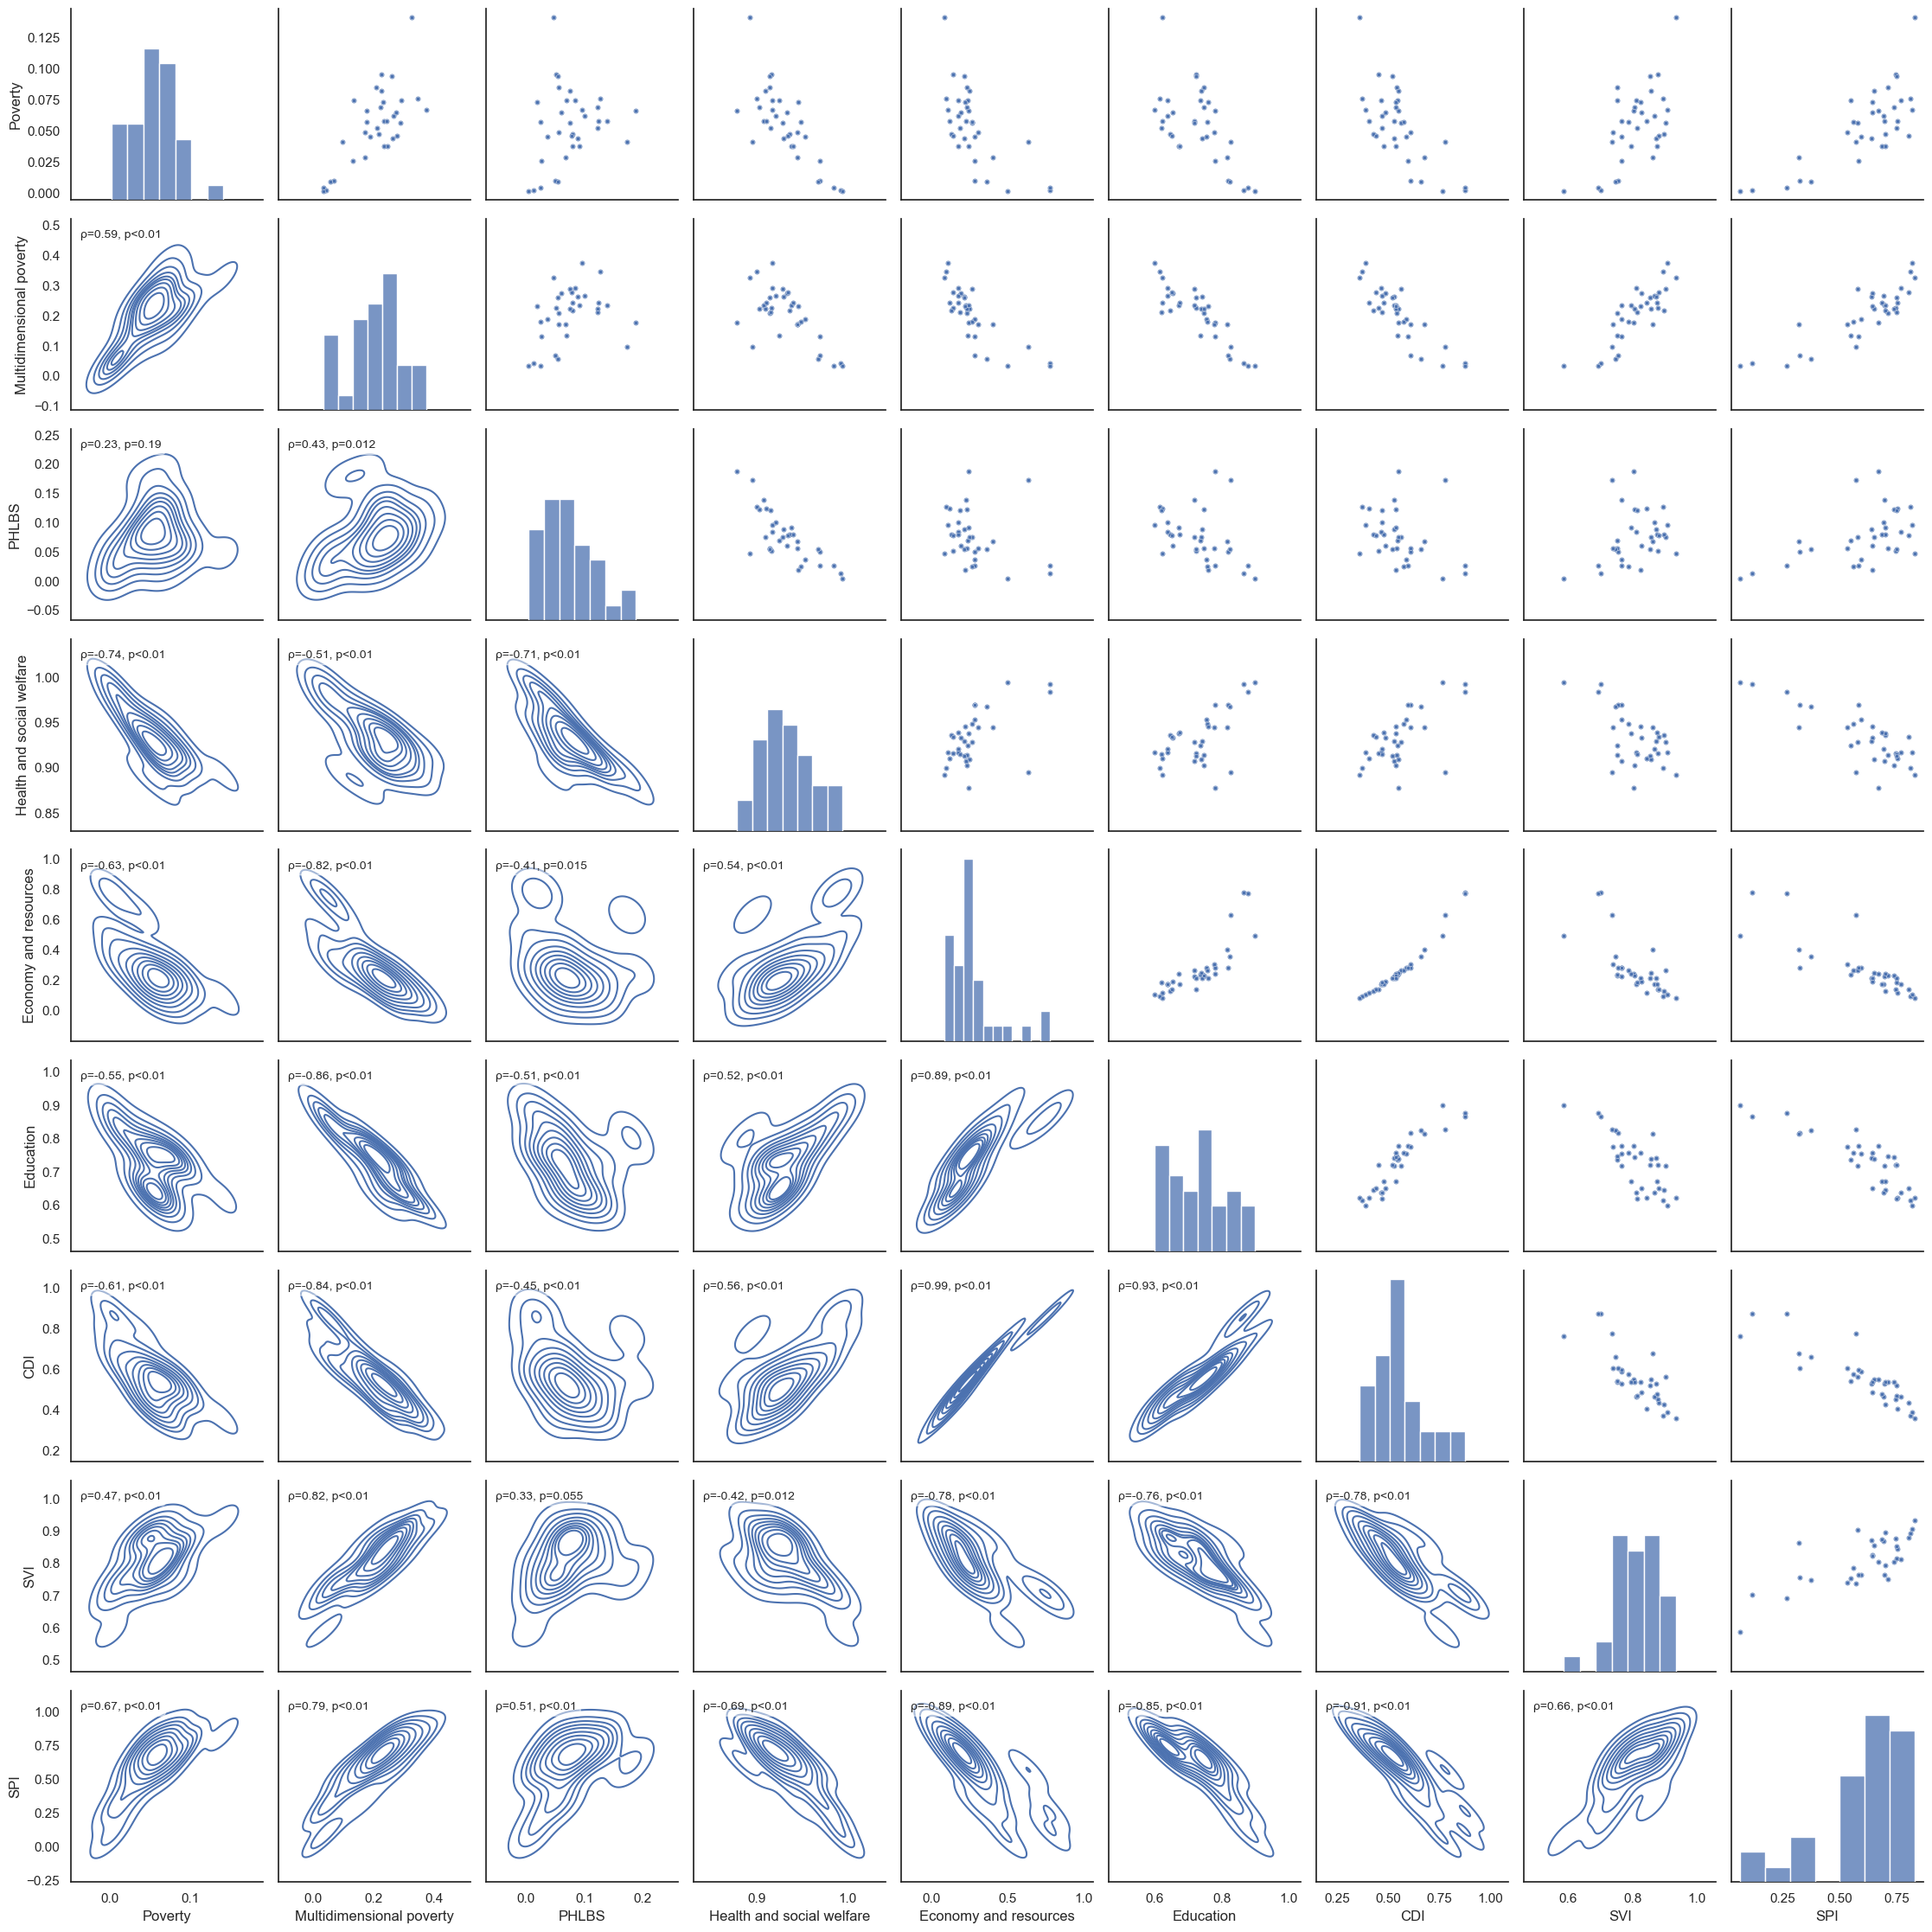

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
sns.set(style="white", font_scale=1)

grupSantiago = groupall.loc[groupall.Metropolitan_Area == 'Metropolitan_Area']
g = sns.PairGrid(grupSantiago, vars=idcs[5:],)
g.map_upper(plt.scatter, s=10)
g.map_upper(sns.scatterplot, s=10)
g.map_diag(sns.histplot, kde=False)
g.map_lower(sns.kdeplot)
g.map_lower(spearmanrfunc, pv=ALPHA)
# g.map_lower(shapirofunc, pv=ALPHA)
# g.map_lower(normaltestfunc, pv=ALPHA)
plt.tight_layout()
#plt.savefig(f'outputs/{fecha}/Figure_1.pdf', dpi=300)
plt.show()

### Vaccination coverage correlates with SES in schools belonging to Santiago, Chile

In [10]:
import geopandas as gpd
from splot.mapping import vba_choropleth
import matplotlib.pyplot as plt
%matplotlib inline
stgo = gpd.read_file('inputs/Comunas/comunas.shp')

import shapely
def clip_area_geodataframe(geodf, bounding_box, buffer=0):
    # bounding box should be in same crs

    bounds = shapely.geometry.box(*bounding_box).buffer(buffer)

    try:
        result = geodf.assign(
            geometry=lambda g: g.map(lambda x: x.intersection(bounds))
        ).pipe(lambda x: x[x.geometry.area > 0])
    except Exception:
        # sometimes there are ill-defined intersections in polygons.
        result = geodf.assign(
            geometry=lambda g: g.buffer(0).map(lambda x: x.intersection(bounds))
        ).pipe(lambda x: x[x.geometry.area > 0])

    return result.set_crs(geodf.crs)

stgo = stgo.set_index(['Region', 'Provincia', 'Comuna', 'cod_comuna']).join(grupMetropolitanal.set_index(['cod_comuna'])).dropna()
#gstgo = stgo.xs('Santiago', level=1, drop_level=False)
gstgo = stgo
bbox = [-70.839390,-33.659768,-70.399645,-33.302161]
bbox2 = [-7885804.8737,-3983208.1895,-7836852.6302,-3935479.8341]
bbox2 = [-7884893.0039,-3980191.9127,-7831737.9181,-3935888.2945]

gstgo2 = clip_area_geodataframe(gstgo, bbox2)
import mapclassify
ix = 'CDI'
n_categories = 3
poverty_bin = mapclassify.FisherJenks(gstgo2[ix], k=n_categories)
porc_vacu_bin = mapclassify.FisherJenks(gstgo['porc_vacu'], k=n_categories)

import numpy as np
cmap_xy = []
bivariate_palette = {}
jscolor = {
    0: ['#e8e8e8', '#e4acac', '#c86a5a', '#b0d5df', '#ad9ea5', '#985356', '#64acbe', '#627f8c', '#574249'],
    1: ['#e8e8e8', '#ace4e4', '#5ac8c8', '#dfb0d6', '#a5add3', '#5698b9', '#be64ac', '#8c62aa', '#3b4994'],
    2: ['#e8e8e8', '#b5c0da', '#6c83b5', '#b8d6be', '#90b2b3', '#567994', '#73ae80', '#5a9178', '#2a5a5b'],
    3: ['#e8e8e8', '#e4d9ac', '#c8b35a', '#cbb8d7', '#c8ada0', '#af8e53', '#9972af', '#976b82', '#804d36'],
    4: ['#4992C8', '#41617D', '#343434', '#AECBEA', '#A3A3A3', '#77583F', '#F1F1F1', '#E4C2A9', '#B98049'],
    5: ['#B873C0', '#755379', '#353535', '#E0BCE5', '#A2A2A2', '#416842', '#F1F1F1', '#AAD2AB', '#4D9D4F'],
    6: ['#64ACBE', '#627F8C', '#574249', '#B0D5DF', '#AD9EA5', '#985356', '#E8E8E8', '#E4ACAC', '#C85A5A'],
    7: ['#F3B300', '#B36600', '#000000', '#F3E6B3', '#B3B3B3', '#376387', '#F3F3F3', '#B4D3E1', '#509DC2'],
    8: ['#73AE80', '#5A9178', '#2A5A5B', '#B8D6BE', '#90B2B3', '#567994', '#E8E8E8', '#B5C0DA', '#6C83B5'],
    9: ['#9972AF', '#976B82', '#804D36', '#CBB8D7', '#C8ADA0', '#AF8E53', '#E8E8E8', '#E4D9AC', '#C8B35A'],
    10: ['#E6A3D0', '#BC9FCE', '#7B8EAF', '#EAC5DD', '#9EC6D3', '#7FC6B1', '#F3F3F3', '#C2F1CE', '#8BE2AF'],
    11: ['#DE4FA6', '#B03598', '#2A1A8A', '#E5B4D9', '#B8B3D8', '#3983BB', '#E8E6F2', '#B5D3E7', '#4FADD0'],
    12: ['#BE64AC', '#8C62AA', '#3B4994', '#DFB0D6', '#A5ADD3', '#5698B9', '#E8E8E8', '#ACE4E4', '#5AC8C8'],
}

schc = np.rot90(np.array(jscolor[7]).reshape(3,3), 0)

for j in range(3):
    for i in range(3):
        cordenadas = (j,i)
        c = schc[cordenadas]
        bivariate_palette[cordenadas] = c
        cmap_xy.append(tuple(int(c.strip('#')[i:i+2], 16)/255 for i in (0, 2, 4)))
cmap_xy = np.array(cmap_xy).reshape(3, 3, 3)
        


#### Figure 1

/Users/enzo/miniforge3/lib/python3.9/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/Users/enzo/miniforge3/lib/python3.9/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/Users/enzo/miniforge3/lib/python3.9/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/Users/enzo/miniforge3/lib/python3.9/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


Text(1, 1.25, 'B')

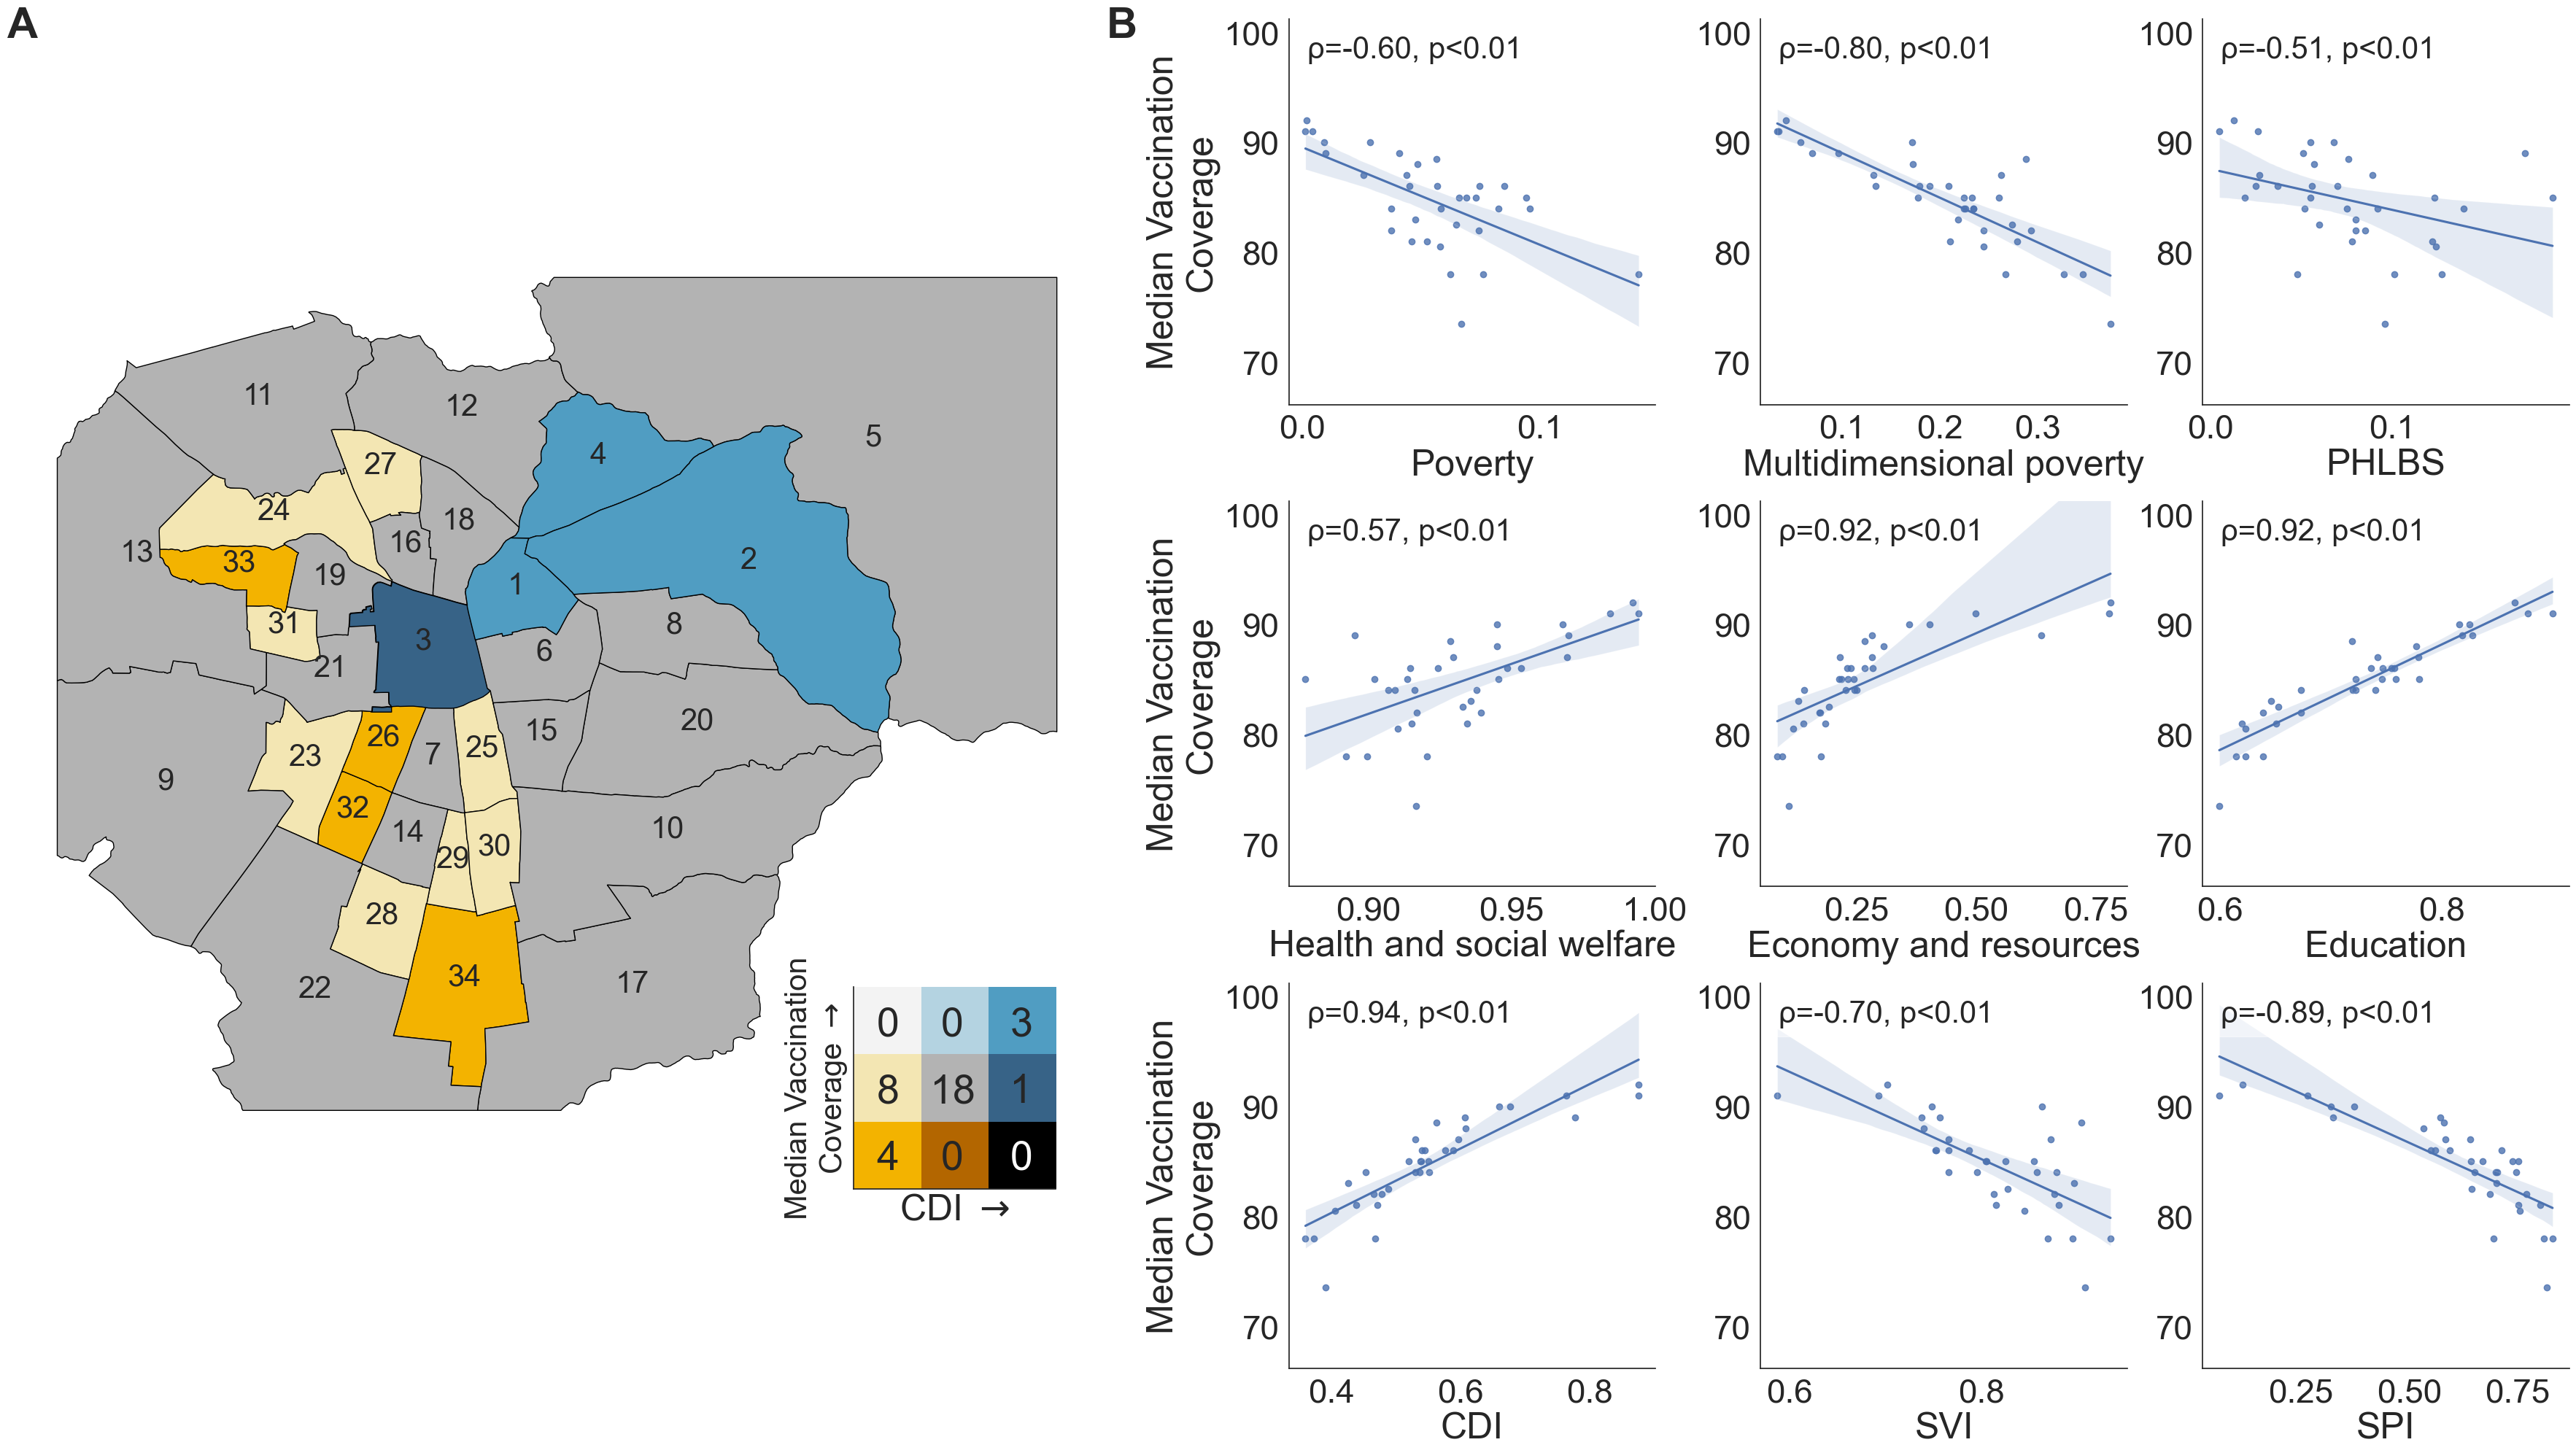

In [12]:

to_legend = {}
gstgo2['cdirank'] = gstgo2[ix].rank(ascending=False)
#fig, ax = plt.subplots(1, 2, figsize=(16, 9))
sns.set(style="white", font_scale=3)

fig, ax = plt.subplot_mosaic("AAABCD;AAAEFG;AAAHIJ", figsize=(16*2.2, 9*2.2), constrained_layout=True)
# ahora hacemos iteraciones anidadas, porque queremos las combinaciones de dos categorías
for j in range(n_categories):
    for i in range(n_categories):
        # buscamos las áreas que tienen ambos valores de categoría
        # areas_in_this_category = set(np.where(poverty_bin.yb == j)[0]) & set(np.where(porc_vacu_bin.yb == i)[0])
        areas_in_this_category = gstgo2.loc[(gstgo2.vac_lab == j) & (gstgo2.CDI_lab == i)].index.get_level_values('cod_comuna')
        to_legend[(j,i)] = areas_in_this_category
        gstgo2.loc[gstgo2.index.get_level_values('cod_comuna').isin(areas_in_this_category)].plot(color=bivariate_palette[(j, i)], ax=ax['A'], edgecolor='black')
        # gstgo2.iloc[list(areas_in_this_category)].plot(color=bivariate_palette[(j, i)], ax=ax['A'], edgecolor='black')
        to_legend[(j,i)] = areas_in_this_category
ax['A'].set_axis_off()
#ax.add_artist(ScaleBar(1, location='lower left', border_pad=3))

# dibujamos la leyenda. el parámetro de axes es la posición (x, y) y el ancho (width, height) de la leyenda.
a = fig.add_axes([.32, .18, .1, .14], facecolor='y')
a.imshow(cmap_xy, origin='lower')

a.set_xlabel(f'{ix} $\\rightarrow$', fontsize='medium')
a.set_ylabel('Median Vaccination\nCoverage $\\rightarrow$', fontsize='small')
a.set_xticks([])
a.set_yticks([])
sns.despine(ax=a)
# dibujamos la leyenda. el parámetro de axes es la posición (x, y) y el ancho (width, height) de la leyenda.
#a = fig.add_axes([.30, .18, .1, .14], facecolor='y')
#a.imshow(cmap_xy, origin='lower')

a.set_xlabel('CDI $\\rightarrow$', fontsize='medium')
a.set_ylabel('Median Vaccination\nCoverage $\\rightarrow$', fontsize='small')
a.set_xticks([])
a.set_yticks([])
sns.despine(ax=a)
# Show number in cmap
a.text(0.17, 0.15, len(to_legend[(0,0)]), transform=a.transAxes, fontsize=40, ha='center', va='center')
a.text(0.49, 0.15, len(to_legend[(0,1)]), transform=a.transAxes, fontsize=40, ha='center', va='center')
a.text(0.83, 0.15, len(to_legend[(0,2)]), transform=a.transAxes, fontsize=40, ha='center', va='center', color='w')
a.text(0.17, 0.48, len(to_legend[(1,0)]), transform=a.transAxes, fontsize=40, ha='center', va='center')
a.text(0.49, 0.48, len(to_legend[(1,1)]), transform=a.transAxes, fontsize=40, ha='center', va='center')
a.text(0.83, 0.48, len(to_legend[(1,2)]), transform=a.transAxes, fontsize=40, ha='center', va='center')
a.text(0.17, 0.81, len(to_legend[(2,0)]), transform=a.transAxes, fontsize=40, ha='center', va='center')
a.text(0.49, 0.81, len(to_legend[(2,1)]), transform=a.transAxes, fontsize=40, ha='center', va='center')
a.text(0.83, 0.81, len(to_legend[(2,2)]), transform=a.transAxes, fontsize=40, ha='center', va='center')

gstgo2.apply(lambda x: ax['A'].annotate(text=int(x['cdirank']), xy=x.geometry.centroid.coords[0], ha='center', fontsize='small'), axis=1);
#Annote W
for x in to_legend[(0,2)]:
    ax['A'].annotate(text=int(gstgo2.query(f"cod_comuna == {x}")['cdirank']), xy=gstgo2.loc[gstgo2.index.get_level_values('cod_comuna') == x].geometry.centroid.to_list()[0].coords[0], ha='center', fontsize='small', color='w');
dicxlim = {
'Poverty': (-0.005705000000000001, 0.148405),
'Multidimensional poverty': (0.016739999999999994, 0.39206),
'PHLBS': (-0.00415, 0.19715),
'Health and social welfare': (0.872275, 1.0004250000000001),
'Economy and resources': (0.049409999999999996, 0.81479),
'Education': (0.584465, 0.915235),
'CDI': (0.33464, 0.90136),
'SVI': (0.57023710745, 0.95134432955),
'SPI': (0.024215, 0.868685),
}

ALPHA = 0.05
bbox = dict(boxstyle="round", fc="1", alpha=0.5)
size = "small"
        
idcs = ['Municipality', 'Province', 'Region', 'Macroregion', 'Poverty', 'Multidimensional poverty', 'PHLBS', 'Health and social welfare', 'Economy and resources', 'Education', 'CDI', 'SVI', 'SPI']
ses = idcs[4:]
lses = 'BCDEFGHIJ'
pv = 0.01
#test = pd.melt(grupMetropolitanal.reset_index(), id_vars=['Municipality', 'porc_vacu'], value_vars=idcs[4:], ignore_index = False)
for l, s in zip(lses,ses):
    r, p = stats.spearmanr(grupMetropolitanal[s], grupMetropolitanal['porc_vacu'])
    sns.regplot(x=s, y='porc_vacu', data=grupMetropolitanal, ax=ax[l], x_jitter=0, y_jitter=0)
    ax[l].set_ylim(grupMetropolitanal.porc_vacu.min()*0.9,grupMetropolitanal.porc_vacu.max()*1.1)
    if s in ['Poverty', 'Health and social welfare', 'CDI']:
        ax[l].set_ylabel('Median Vaccination\nCoverage')
    else:
        ax[l].set_ylabel(None)
    if p < pv:
        ax[l].annotate(f'ρ={r:.2f}, p<{pv}',
                    xy=(.05, .90), xycoords=ax[l].transAxes, bbox=bbox, fontsize=size)
    else:
        ax[l].annotate(f'ρ={r:.2f}, p={p:.2g}',
                    xy=(.05, .90), xycoords=ax[l].transAxes, bbox=bbox, fontsize=size)
    ax[l].set_xlim(dicxlim[s])
    sns.despine(ax=ax[l])

ax['A'].text(0, 1.25, 'A', transform=ax['A'].transAxes,
        fontsize=42, fontweight='bold', va='top')
ax['A'].text(1, 1.25, 'B', transform=ax['A'].transAxes,
        fontsize=42, fontweight='bold', va='top')

#plt.tight_layout()
#plt.savefig(f'outputs/{fecha}/Figure_2_Santiago_Province_FIG1.pdf', dpi=300, bbox_inches='tight')


#### Supplementary Figure 2

/Users/enzo/miniforge3/lib/python3.9/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/Users/enzo/miniforge3/lib/python3.9/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/Users/enzo/miniforge3/lib/python3.9/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/Users/enzo/miniforge3/lib/python3.9/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/Users/enzo/miniforge3/lib/python3.9/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


Text(1, 1.25, 'B')

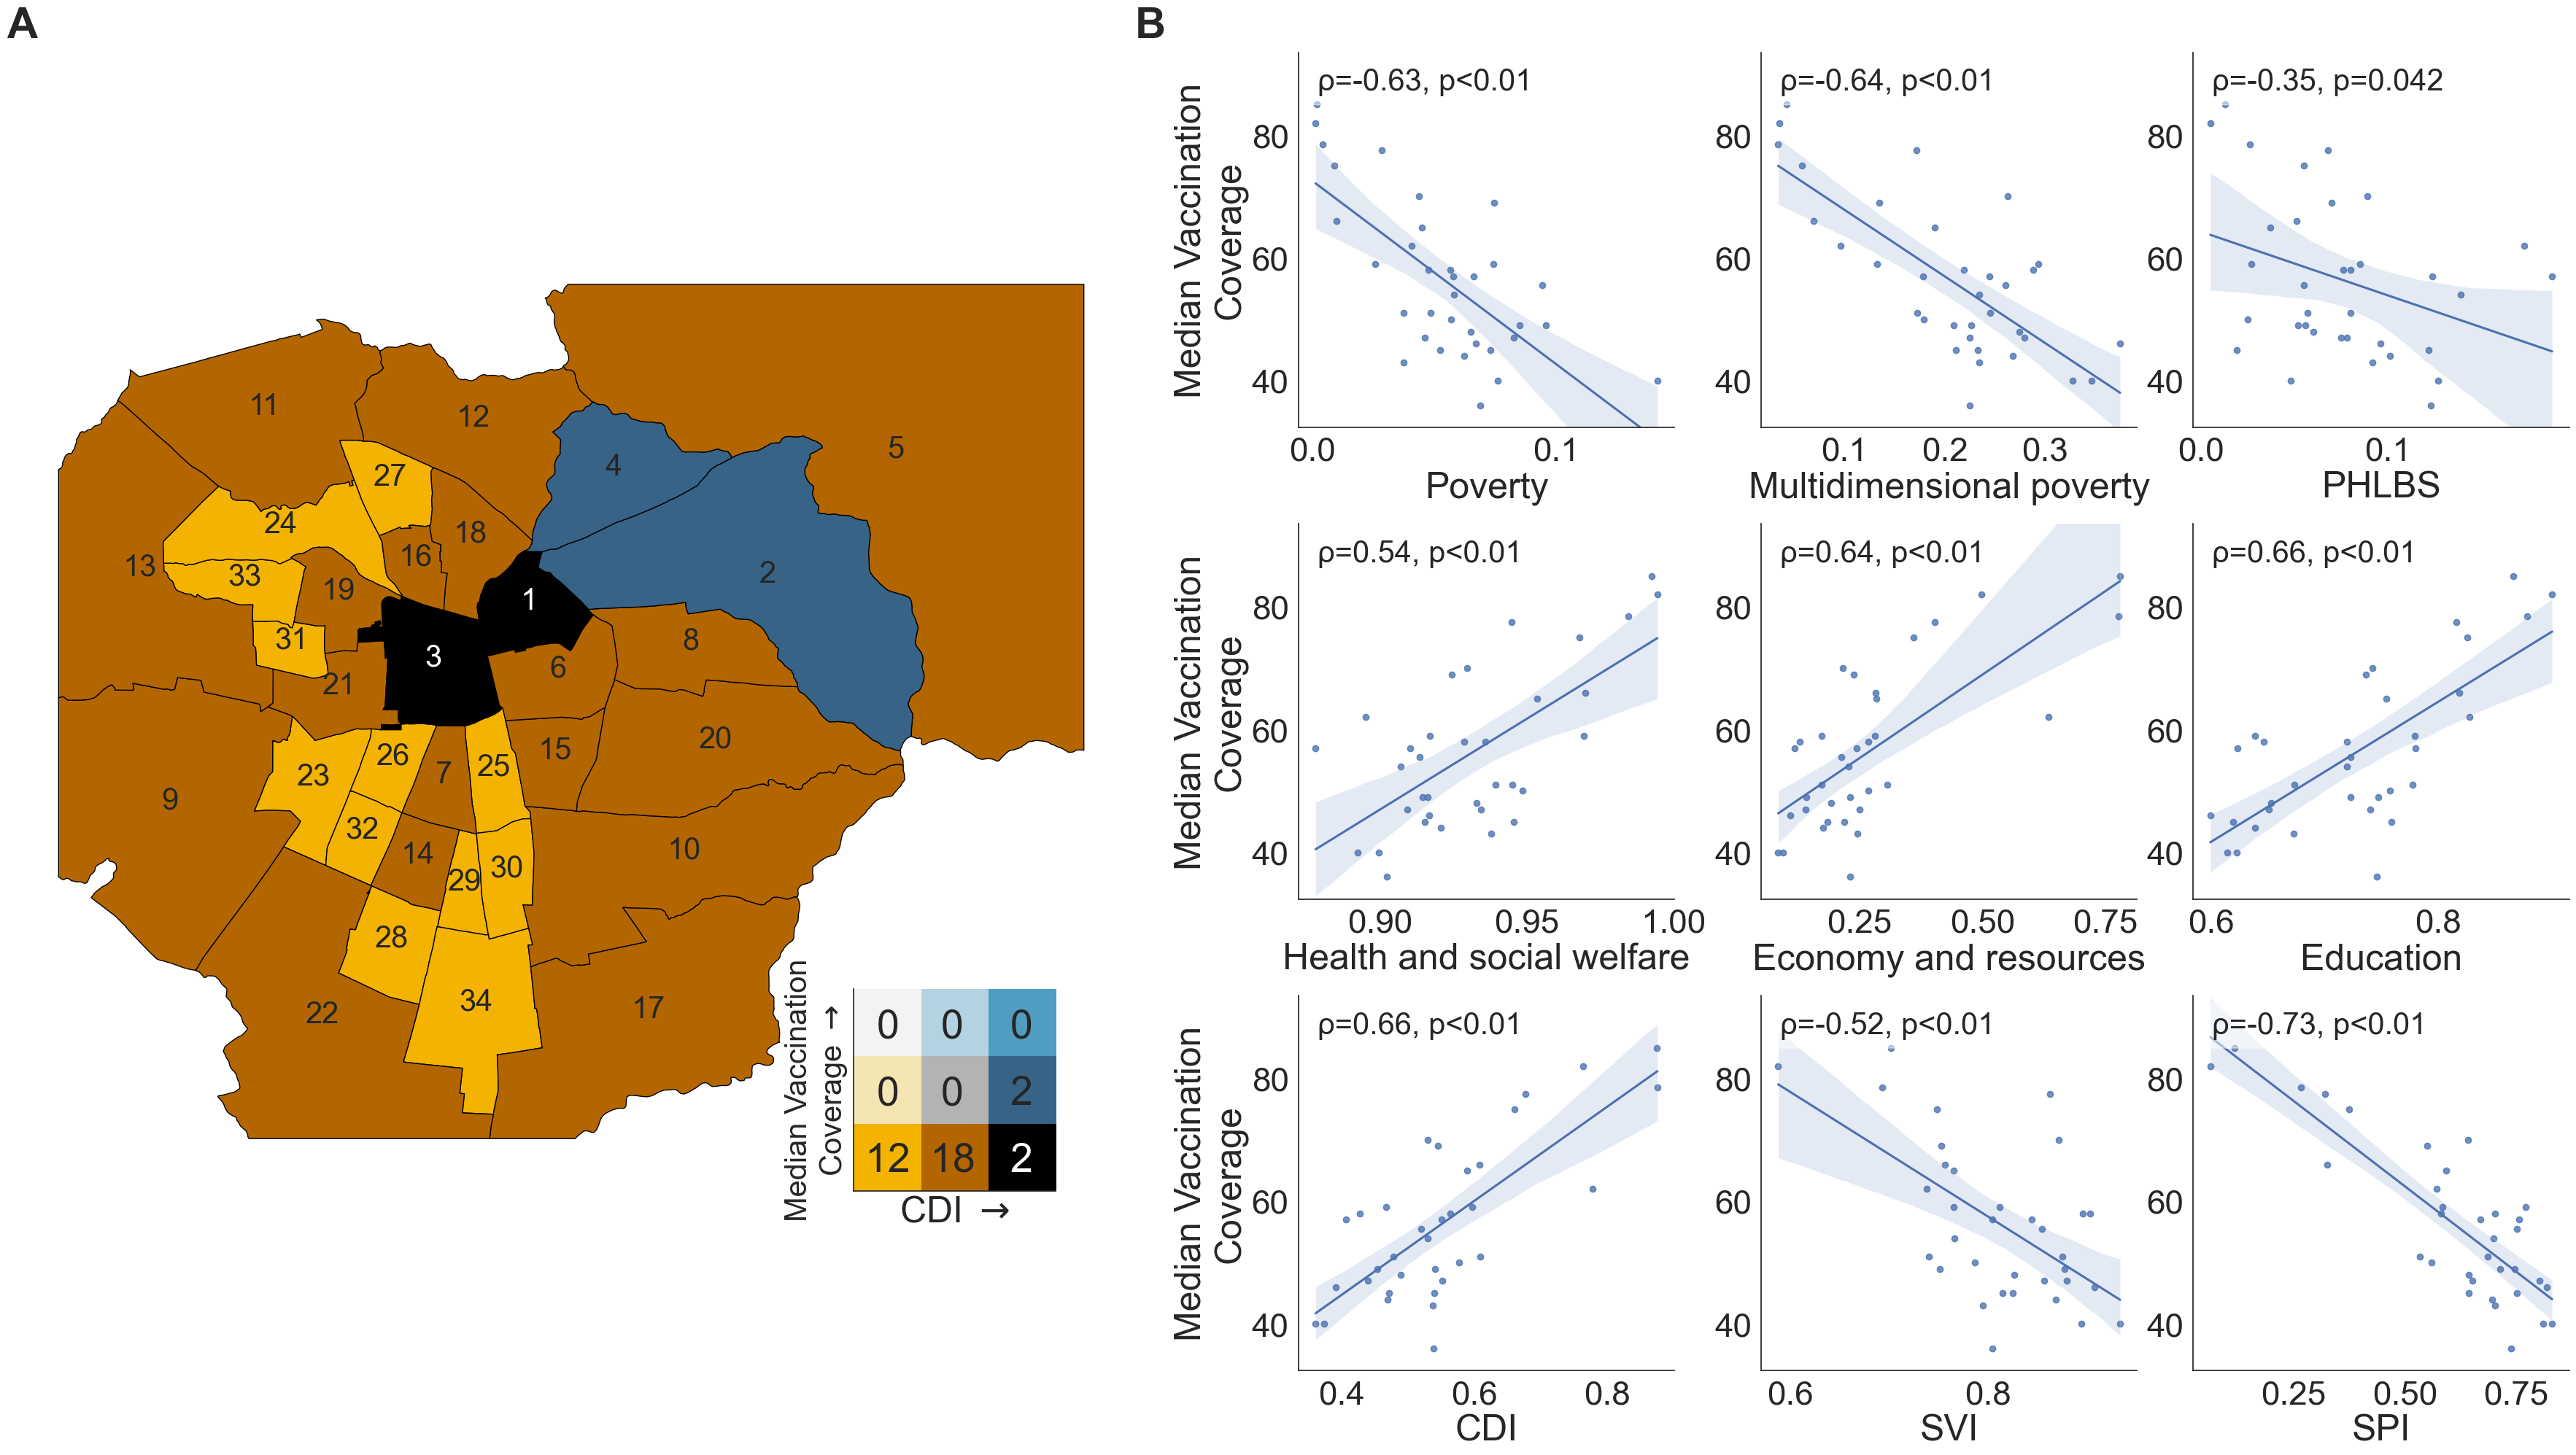

In [13]:
fecha_ = '2021_11_15'
fecha = fecha_.replace('_','-')
json_dir = Path(f'vaccines_data/vacunacionescolar.mineduc.cl_{fecha_}/json')
json_dir.mkdir(parents=True, exist_ok=True)

def download_json_vac():
    directory = 'https://vacunacionescolar.mineduc.cl/json/'
    cli = f'wget -N --random-wait -r -p -e robots=off -U mozilla  {directory}'
    out = run(cli, shell=True, capture_output=True)
    return True

# download_json_vac()
# mineduc data in http://datos.mineduc.cl/dashboards/20015/DESCA-BASES-DE-DATOS-DIREC/
# COD_DEPE2: Código de Dependencia del Establecimiento (agrupado):
#     1: Municipal
#     2: Particular Subvencionado 
#     3: Particular Pagado
#     4: Corp. De Administración Delegada (DL 3166)
#     5: Servicio Local de Educación
# RURAL_RBD: Indicador de ruralidad
#     0: Urbano 
#     1:Rural
# ESTADO_ESTAB: Estado del establecimiento
#     1: Funcionando 
#     2: En receso 
#     3: Cerrado
#     4: Autorizado sin matrícula
# ORI_RELIGIOSA: Orientación Religiosa del Establecimiento
#     1: Orientación religiosa Laica
#     2: Orientación religiosa Católica 
#     3: Orientación religiosa Evangélica 
#     4: Orientación Musulmana
#     5: Orientación Judía
#     6: Orientación Budista
#     7: Orientación religiosa Otro 
#     9: Sin información
COD_DEPE2_tr = {
    1: 'Municipal',
    2: 'Particular Subvencionado',
    3: 'Particular Pagado',
    4: 'Corp. De Administración Delegada (DL 3166)',
    5: 'Servicio Local de Educación',
}
RURAL_RBD_tr = {
    0: 'Urbano',
    1: 'Rural ',
}
ESTADO_ESTAB_tr = {
    1: 'Funcionando',
    2: 'En receso ',
    3: 'Cerrado',
    4: 'Autorizado sin matrícula',
}
ORI_RELIGIOSA_tr = {
    1: 'Laica',
    2: 'Católica ',
    3: 'Evangélica',
    4: 'Musulmana',
    5: 'Judía',
    6: 'Budista',
    7: 'Otro',
    9: 'Sin información',
}
data_vac = list(json_dir.glob('*Establecimientos.json'))
vacunaciones = pd.read_json(data_vac[0])
for data in data_vac[1:]:
    #vacunaciones = vacunaciones.append(pd.read_json(data), ignore_index=True)
    vacunaciones = pd.concat([vacunaciones, pd.read_json(data)], ignore_index=True)
vacunaciones = vacunaciones.set_index('rbd')
update_time = datetime.datetime.fromtimestamp(data_vac[0].stat().st_mtime)
date = update_time.strftime('%Y-%m-%d')
# vacunaciones.index.unique()
# vacunaciones
mineduc = pd.read_csv('inputs/mineduc_data/20210927_Directorio_Oficial_EE_2021_20210430_WEB.csv', sep=';')
mineduc = mineduc.set_index('RBD')
mineduc['LATITUD'] = mineduc['LATITUD'].str.replace(',', '.')
mineduc['LONGITUD'] = mineduc['LONGITUD'].str.replace(',', '.')
mineduc["LATITUD"] = pd.to_numeric(mineduc["LATITUD"], errors='coerce')
mineduc["LONGITUD"] = pd.to_numeric(mineduc["LONGITUD"], errors='coerce')

mineduc["COD_DEPE2_mp"] = mineduc["COD_DEPE2"].map(COD_DEPE2_tr)
mineduc["RURAL_RBD_mp"] = mineduc["RURAL_RBD"].map(RURAL_RBD_tr)
cursos = ['Medio mayor', 'Prekínder', 'Kínder', '1° básico', '2° básico', '3° básico', '4° básico', '5° básico', '6° básico', '7° básico', '8° básico', '1° medio', '2° medio', '3° medio', '4° medio']

macroregion = {
    'Arica y Parinacota':'Northern',
    'Tarapacá':'Northern',
    'Antofagasta':'Northern',
    'Atacama':'Northern',
    'Coquimbo':'Center',
    'Valparaíso':'Center',
    "O'Higgins":'South Central',
    'Ñuble':'South Central',
    'Maule':'South Central',
    'Biobío':'South Central',
    'Araucanía':'Southern',
    'Los Ríos':'Southern',
    'Los Lagos':'Southern',
    'Aysén':'Austral',
    'Magallanes':'Austral',
    'Metropolitana':'Metropolitan',
}
idc = pd.read_csv('inputs/cut_idc_pvrty.csv', sep=',', index_col=0)
idc['Macroregion'] = idc['Region'].map(macroregion)
# idc
columns_to_merge = ['COD_DEPE2_mp', 'RURAL_RBD', 'ORI_RELIGIOSA', 'COD_COM_RBD', 'LATITUD', 'LONGITUD']
idcs = ['Municipality', 'Province', 'Region', 'Metropolitan_Area', 'Macroregion', 'Poverty', 'Multidimensional poverty', 'PHLBS', 'Health and social welfare', 'Economy and resources', 'Education', 'CDI', 'SVI', 'SPI']
# idcs = ['Municipality', 'CDI', 'SVI', 'SPI']
result = pd.merge(vacunaciones.reset_index(), mineduc[columns_to_merge], left_on = 'rbd', right_index = True, how = 'left')
result = pd.merge(result, idc[idcs], left_on = 'COD_COM_RBD', right_index = True, how = 'left')
result = result.drop(columns=['nom_region'])
result = result.loc[(result.Metropolitan_Area == 'Metropolitan_Area') & (result.nivel_alu.isin(cursos))]

# result
groupall = result.groupby(['COD_COM_RBD','Region', 'Province', 'Metropolitan_Area', 'Municipality', 'Macroregion'], as_index=False).median()

grupMetropolitanal = groupall.loc[groupall.Metropolitan_Area == 'Metropolitan_Area']
grupMetropolitanal = grupMetropolitanal.drop(columns=['rbd','porc_novacunados','RURAL_RBD','ORI_RELIGIOSA','porc_vacuincom','LATITUD','LONGITUD'])
grupMetropolitanal= grupMetropolitanal.rename({'COD_COM_RBD':'cod_comuna'}, axis=1)
vac_bins = [0, 80, 90, 100]
spi_bins = [0, 0.5, 0.7, 1]
grupMetropolitanal['vac_lab'] = pd.cut(grupMetropolitanal.porc_vacu, vac_bins, labels=[0,1,2])
grupMetropolitanal['CDI_lab'] = pd.cut(grupMetropolitanal.CDI, spi_bins, labels=[0,1,2])
grupMetropolitanal

stgo = gpd.read_file('inputs/Comunas/comunas.shp')

def clip_area_geodataframe(geodf, bounding_box, buffer=0):
    # bounding box should be in same crs

    bounds = shapely.geometry.box(*bounding_box).buffer(buffer)

    try:
        result = geodf.assign(
            geometry=lambda g: g.map(lambda x: x.intersection(bounds))
        ).pipe(lambda x: x[x.geometry.area > 0])
    except Exception:
        # sometimes there are ill-defined intersections in polygons.
        result = geodf.assign(
            geometry=lambda g: g.buffer(0).map(lambda x: x.intersection(bounds))
        ).pipe(lambda x: x[x.geometry.area > 0])

    return result.set_crs(geodf.crs)

stgo = stgo.set_index(['Region', 'Provincia', 'Comuna', 'cod_comuna']).join(grupMetropolitanal.set_index(['cod_comuna'])).dropna()
#gstgo = stgo.xs('Santiago', level=1, drop_level=False)
gstgo = stgo
bbox = [-70.839390,-33.659768,-70.399645,-33.302161]
bbox2 = [-7885804.8737,-3983208.1895,-7836852.6302,-3935479.8341]
bbox2 = [-7884893.0039,-3980191.9127,-7831737.9181,-3935888.2945]

gstgo2 = clip_area_geodataframe(gstgo, bbox2)
ix = 'CDI'
n_categories = 3
poverty_bin = mapclassify.FisherJenks(gstgo2[ix], k=n_categories)
porc_vacu_bin = mapclassify.FisherJenks(gstgo['porc_vacu'], k=n_categories)

cmap_xy = []
bivariate_palette = {}
jscolor = {
    0: ['#e8e8e8', '#e4acac', '#c86a5a', '#b0d5df', '#ad9ea5', '#985356', '#64acbe', '#627f8c', '#574249'],
    1: ['#e8e8e8', '#ace4e4', '#5ac8c8', '#dfb0d6', '#a5add3', '#5698b9', '#be64ac', '#8c62aa', '#3b4994'],
    2: ['#e8e8e8', '#b5c0da', '#6c83b5', '#b8d6be', '#90b2b3', '#567994', '#73ae80', '#5a9178', '#2a5a5b'],
    3: ['#e8e8e8', '#e4d9ac', '#c8b35a', '#cbb8d7', '#c8ada0', '#af8e53', '#9972af', '#976b82', '#804d36'],
    4: ['#4992C8', '#41617D', '#343434', '#AECBEA', '#A3A3A3', '#77583F', '#F1F1F1', '#E4C2A9', '#B98049'],
    5: ['#B873C0', '#755379', '#353535', '#E0BCE5', '#A2A2A2', '#416842', '#F1F1F1', '#AAD2AB', '#4D9D4F'],
    6: ['#64ACBE', '#627F8C', '#574249', '#B0D5DF', '#AD9EA5', '#985356', '#E8E8E8', '#E4ACAC', '#C85A5A'],
    7: ['#F3B300', '#B36600', '#000000', '#F3E6B3', '#B3B3B3', '#376387', '#F3F3F3', '#B4D3E1', '#509DC2'],
    8: ['#73AE80', '#5A9178', '#2A5A5B', '#B8D6BE', '#90B2B3', '#567994', '#E8E8E8', '#B5C0DA', '#6C83B5'],
    9: ['#9972AF', '#976B82', '#804D36', '#CBB8D7', '#C8ADA0', '#AF8E53', '#E8E8E8', '#E4D9AC', '#C8B35A'],
    10: ['#E6A3D0', '#BC9FCE', '#7B8EAF', '#EAC5DD', '#9EC6D3', '#7FC6B1', '#F3F3F3', '#C2F1CE', '#8BE2AF'],
    11: ['#DE4FA6', '#B03598', '#2A1A8A', '#E5B4D9', '#B8B3D8', '#3983BB', '#E8E6F2', '#B5D3E7', '#4FADD0'],
    12: ['#BE64AC', '#8C62AA', '#3B4994', '#DFB0D6', '#A5ADD3', '#5698B9', '#E8E8E8', '#ACE4E4', '#5AC8C8'],
}

schc = np.rot90(np.array(jscolor[7]).reshape(3,3), 0)

for j in range(3):
    for i in range(3):
        cordenadas = (j,i)
        c = schc[cordenadas]
        bivariate_palette[cordenadas] = c
        cmap_xy.append(tuple(int(c.strip('#')[i:i+2], 16)/255 for i in (0, 2, 4)))
cmap_xy = np.array(cmap_xy).reshape(3, 3, 3)
        

to_legend = {}
gstgo2['cdirank'] = gstgo2[ix].rank(ascending=False)
#fig, ax = plt.subplots(1, 2, figsize=(16, 9))
sns.set(style="white", font_scale=3)

fig, ax = plt.subplot_mosaic("AAABCD;AAAEFG;AAAHIJ", figsize=(16*2.2, 9*2.2), constrained_layout=True)
# ahora hacemos iteraciones anidadas, porque queremos las combinaciones de dos categorías
for j in range(n_categories):
    for i in range(n_categories):
        # buscamos las áreas que tienen ambos valores de categoría
        # areas_in_this_category = set(np.where(poverty_bin.yb == j)[0]) & set(np.where(porc_vacu_bin.yb == i)[0])
        areas_in_this_category = gstgo2.loc[(gstgo2.vac_lab == j) & (gstgo2.CDI_lab == i)].index.get_level_values('cod_comuna')
        to_legend[(j,i)] = areas_in_this_category
        gstgo2.loc[gstgo2.index.get_level_values('cod_comuna').isin(areas_in_this_category)].plot(color=bivariate_palette[(j, i)], ax=ax['A'], edgecolor='black')
        # gstgo2.iloc[list(areas_in_this_category)].plot(color=bivariate_palette[(j, i)], ax=ax['A'], edgecolor='black')
        to_legend[(j,i)] = areas_in_this_category
ax['A'].set_axis_off()
#ax.add_artist(ScaleBar(1, location='lower left', border_pad=3))

# dibujamos la leyenda. el parámetro de axes es la posición (x, y) y el ancho (width, height) de la leyenda.
a = fig.add_axes([.32, .18, .1, .14], facecolor='y')
a.imshow(cmap_xy, origin='lower')

a.set_xlabel(f'{ix} $\\rightarrow$', fontsize='medium')
a.set_ylabel('Median Vaccination\nCoverage $\\rightarrow$', fontsize='small')
a.set_xticks([])
a.set_yticks([])
sns.despine(ax=a)
# dibujamos la leyenda. el parámetro de axes es la posición (x, y) y el ancho (width, height) de la leyenda.
#a = fig.add_axes([.30, .18, .1, .14], facecolor='y')
#a.imshow(cmap_xy, origin='lower')

a.set_xlabel('CDI $\\rightarrow$', fontsize='medium')
a.set_ylabel('Median Vaccination\nCoverage $\\rightarrow$', fontsize='small')
a.set_xticks([])
a.set_yticks([])
sns.despine(ax=a)
# Show number in cmap
a.text(0.17, 0.15, len(to_legend[(0,0)]), transform=a.transAxes, fontsize=40, ha='center', va='center')
a.text(0.49, 0.15, len(to_legend[(0,1)]), transform=a.transAxes, fontsize=40, ha='center', va='center')
a.text(0.83, 0.15, len(to_legend[(0,2)]), transform=a.transAxes, fontsize=40, ha='center', va='center', color='w')
a.text(0.17, 0.48, len(to_legend[(1,0)]), transform=a.transAxes, fontsize=40, ha='center', va='center')
a.text(0.49, 0.48, len(to_legend[(1,1)]), transform=a.transAxes, fontsize=40, ha='center', va='center')
a.text(0.83, 0.48, len(to_legend[(1,2)]), transform=a.transAxes, fontsize=40, ha='center', va='center')
a.text(0.17, 0.81, len(to_legend[(2,0)]), transform=a.transAxes, fontsize=40, ha='center', va='center')
a.text(0.49, 0.81, len(to_legend[(2,1)]), transform=a.transAxes, fontsize=40, ha='center', va='center')
a.text(0.83, 0.81, len(to_legend[(2,2)]), transform=a.transAxes, fontsize=40, ha='center', va='center')

gstgo2.apply(lambda x: ax['A'].annotate(text=int(x['cdirank']), xy=x.geometry.centroid.coords[0], ha='center', fontsize='small'), axis=1);
#Annote W
for x in to_legend[(0,2)]:
    ax['A'].annotate(text=int(gstgo2.query(f"cod_comuna == {x}")['cdirank']), xy=gstgo2.loc[gstgo2.index.get_level_values('cod_comuna') == x].geometry.centroid.to_list()[0].coords[0], ha='center', fontsize='small', color='w');
dicxlim = {
'Poverty': (-0.005705000000000001, 0.148405),
'Multidimensional poverty': (0.016739999999999994, 0.39206),
'PHLBS': (-0.00415, 0.19715),
'Health and social welfare': (0.872275, 1.0004250000000001),
'Economy and resources': (0.049409999999999996, 0.81479),
'Education': (0.584465, 0.915235),
'CDI': (0.33464, 0.90136),
'SVI': (0.57023710745, 0.95134432955),
'SPI': (0.024215, 0.868685),
}

ALPHA = 0.05
bbox = dict(boxstyle="round", fc="1", alpha=0.5)
size = "small"
        
idcs = ['Municipality', 'Province', 'Region', 'Macroregion', 'Poverty', 'Multidimensional poverty', 'PHLBS', 'Health and social welfare', 'Economy and resources', 'Education', 'CDI', 'SVI', 'SPI']
ses = idcs[4:]
lses = 'BCDEFGHIJ'
pv = 0.01
#test = pd.melt(grupMetropolitanal.reset_index(), id_vars=['Municipality', 'porc_vacu'], value_vars=idcs[4:], ignore_index = False)
for l, s in zip(lses,ses):
    r, p = stats.spearmanr(grupMetropolitanal[s], grupMetropolitanal['porc_vacu'])
    sns.regplot(x=s, y='porc_vacu', data=grupMetropolitanal, ax=ax[l], x_jitter=0, y_jitter=0)
    ax[l].set_ylim(grupMetropolitanal.porc_vacu.min()*0.9,grupMetropolitanal.porc_vacu.max()*1.1)
    if s in ['Poverty', 'Health and social welfare', 'CDI']:
        ax[l].set_ylabel('Median Vaccination\nCoverage')
    else:
        ax[l].set_ylabel(None)
    if p < pv:
        ax[l].annotate(f'ρ={r:.2f}, p<{pv}',
                    xy=(.05, .90), xycoords=ax[l].transAxes, bbox=bbox, fontsize=size)
    else:
        ax[l].annotate(f'ρ={r:.2f}, p={p:.2g}',
                    xy=(.05, .90), xycoords=ax[l].transAxes, bbox=bbox, fontsize=size)
    ax[l].set_xlim(dicxlim[s])
    sns.despine(ax=ax[l])

ax['A'].text(0, 1.25, 'A', transform=ax['A'].transAxes,
        fontsize=42, fontweight='bold', va='top')
ax['A'].text(1, 1.25, 'B', transform=ax['A'].transAxes,
        fontsize=42, fontweight='bold', va='top')

#plt.tight_layout()
#plt.savefig(f'outputs/{fecha}/Figure_2_Santiago_Province_FIG1.pdf', dpi=300, bbox_inches='tight')


#### Supplementary Figure 3

/Users/enzo/miniforge3/lib/python3.9/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/Users/enzo/miniforge3/lib/python3.9/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/Users/enzo/miniforge3/lib/python3.9/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/Users/enzo/miniforge3/lib/python3.9/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


Text(1, 1.25, 'B')

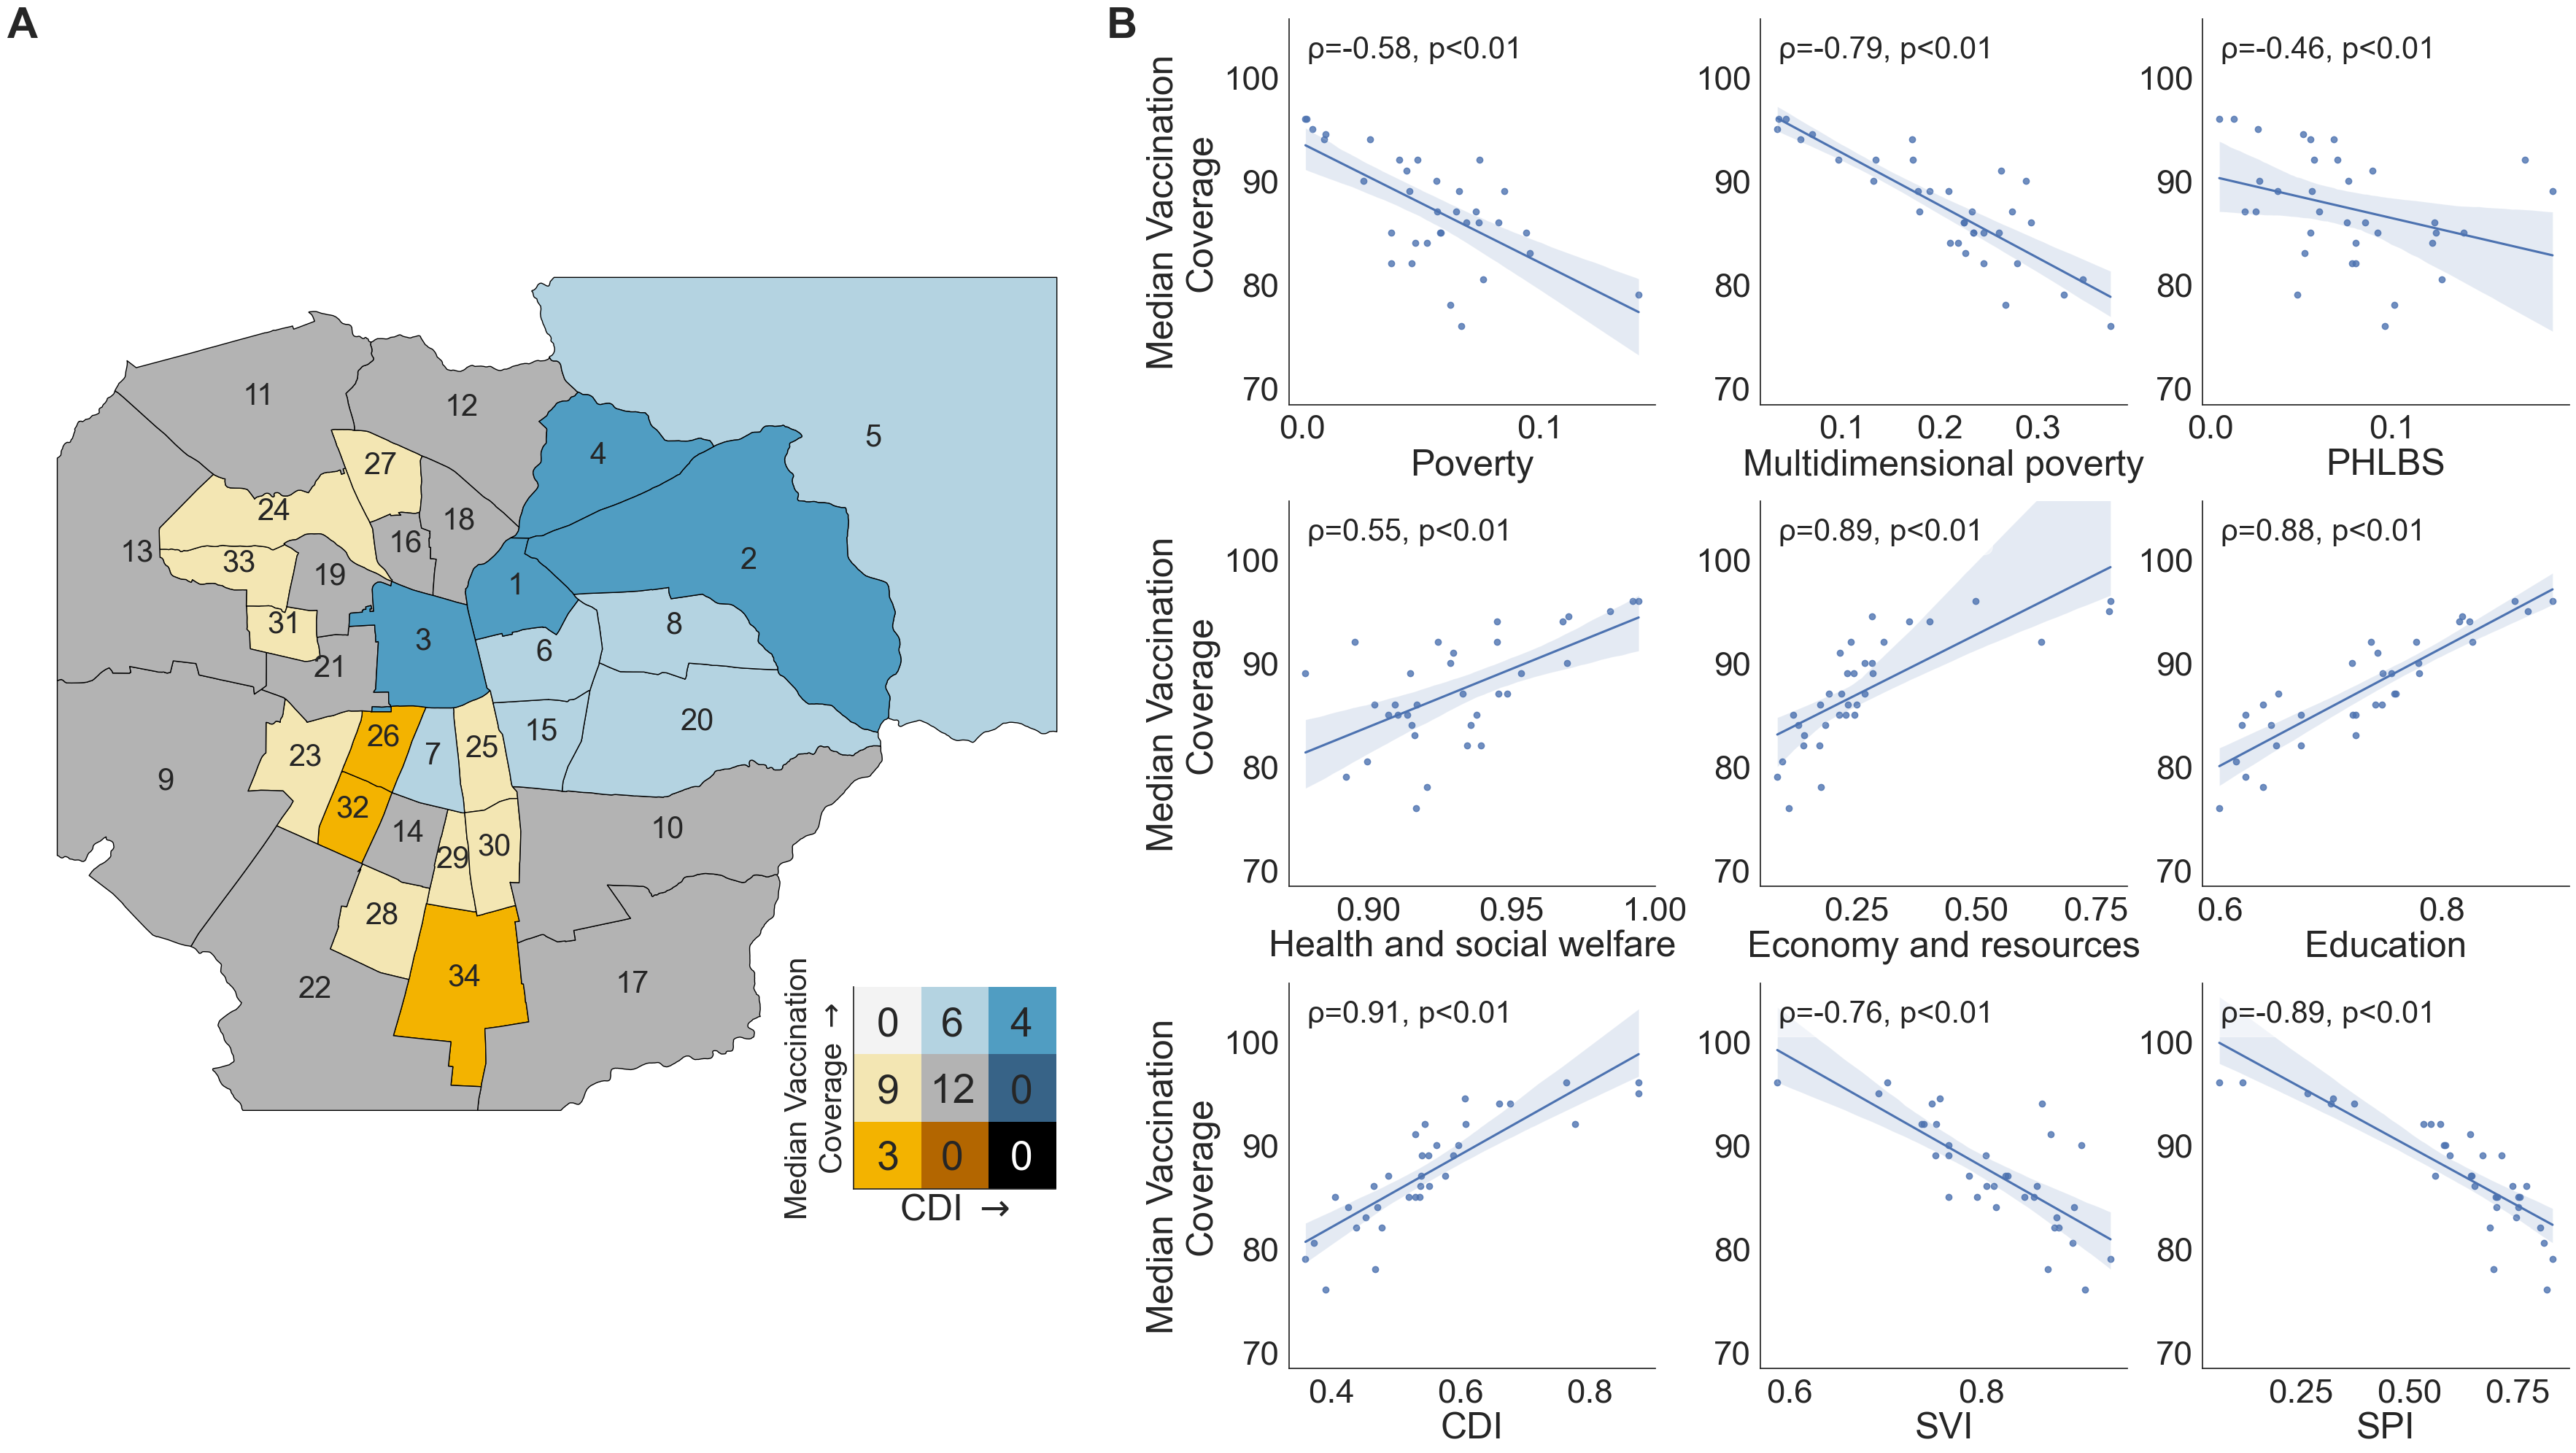

In [14]:
fecha_ = '2022_03_01'
fecha = fecha_.replace('_','-')
json_dir = Path(f'vaccines_data/vacunacionescolar.mineduc.cl_{fecha_}/json')
json_dir.mkdir(parents=True, exist_ok=True)

def download_json_vac():
    directory = 'https://vacunacionescolar.mineduc.cl/json/'
    cli = f'wget -N --random-wait -r -p -e robots=off -U mozilla  {directory}'
    out = run(cli, shell=True, capture_output=True)
    return True

# download_json_vac()
# mineduc data in http://datos.mineduc.cl/dashboards/20015/DESCA-BASES-DE-DATOS-DIREC/
# COD_DEPE2: Código de Dependencia del Establecimiento (agrupado):
#     1: Municipal
#     2: Particular Subvencionado 
#     3: Particular Pagado
#     4: Corp. De Administración Delegada (DL 3166)
#     5: Servicio Local de Educación
# RURAL_RBD: Indicador de ruralidad
#     0: Urbano 
#     1:Rural
# ESTADO_ESTAB: Estado del establecimiento
#     1: Funcionando 
#     2: En receso 
#     3: Cerrado
#     4: Autorizado sin matrícula
# ORI_RELIGIOSA: Orientación Religiosa del Establecimiento
#     1: Orientación religiosa Laica
#     2: Orientación religiosa Católica 
#     3: Orientación religiosa Evangélica 
#     4: Orientación Musulmana
#     5: Orientación Judía
#     6: Orientación Budista
#     7: Orientación religiosa Otro 
#     9: Sin información
COD_DEPE2_tr = {
    1: 'Municipal',
    2: 'Particular Subvencionado',
    3: 'Particular Pagado',
    4: 'Corp. De Administración Delegada (DL 3166)',
    5: 'Servicio Local de Educación',
}
RURAL_RBD_tr = {
    0: 'Urbano',
    1: 'Rural ',
}
ESTADO_ESTAB_tr = {
    1: 'Funcionando',
    2: 'En receso ',
    3: 'Cerrado',
    4: 'Autorizado sin matrícula',
}
ORI_RELIGIOSA_tr = {
    1: 'Laica',
    2: 'Católica ',
    3: 'Evangélica',
    4: 'Musulmana',
    5: 'Judía',
    6: 'Budista',
    7: 'Otro',
    9: 'Sin información',
}
data_vac = list(json_dir.glob('*Establecimientos.json'))
vacunaciones = pd.read_json(data_vac[0])
for data in data_vac[1:]:
    #vacunaciones = vacunaciones.append(pd.read_json(data), ignore_index=True)
    vacunaciones = pd.concat([vacunaciones, pd.read_json(data)], ignore_index=True)
vacunaciones = vacunaciones.set_index('rbd')
update_time = datetime.datetime.fromtimestamp(data_vac[0].stat().st_mtime)
date = update_time.strftime('%Y-%m-%d')
# vacunaciones.index.unique()
# vacunaciones
mineduc = pd.read_csv('inputs/mineduc_data/20210927_Directorio_Oficial_EE_2021_20210430_WEB.csv', sep=';')
mineduc = mineduc.set_index('RBD')
mineduc['LATITUD'] = mineduc['LATITUD'].str.replace(',', '.')
mineduc['LONGITUD'] = mineduc['LONGITUD'].str.replace(',', '.')
mineduc["LATITUD"] = pd.to_numeric(mineduc["LATITUD"], errors='coerce')
mineduc["LONGITUD"] = pd.to_numeric(mineduc["LONGITUD"], errors='coerce')

mineduc["COD_DEPE2_mp"] = mineduc["COD_DEPE2"].map(COD_DEPE2_tr)
mineduc["RURAL_RBD_mp"] = mineduc["RURAL_RBD"].map(RURAL_RBD_tr)
cursos = ['Medio mayor', 'Prekínder', 'Kínder', '1° básico', '2° básico', '3° básico', '4° básico', '5° básico', '6° básico', '7° básico', '8° básico', '1° medio', '2° medio', '3° medio', '4° medio']

macroregion = {
    'Arica y Parinacota':'Northern',
    'Tarapacá':'Northern',
    'Antofagasta':'Northern',
    'Atacama':'Northern',
    'Coquimbo':'Center',
    'Valparaíso':'Center',
    "O'Higgins":'South Central',
    'Ñuble':'South Central',
    'Maule':'South Central',
    'Biobío':'South Central',
    'Araucanía':'Southern',
    'Los Ríos':'Southern',
    'Los Lagos':'Southern',
    'Aysén':'Austral',
    'Magallanes':'Austral',
    'Metropolitana':'Metropolitan',
}
idc = pd.read_csv('inputs/cut_idc_pvrty.csv', sep=',', index_col=0)
idc['Macroregion'] = idc['Region'].map(macroregion)
# idc
columns_to_merge = ['COD_DEPE2_mp', 'RURAL_RBD', 'ORI_RELIGIOSA', 'COD_COM_RBD', 'LATITUD', 'LONGITUD']
idcs = ['Municipality', 'Province', 'Region', 'Metropolitan_Area', 'Macroregion', 'Poverty', 'Multidimensional poverty', 'PHLBS', 'Health and social welfare', 'Economy and resources', 'Education', 'CDI', 'SVI', 'SPI']
# idcs = ['Municipality', 'CDI', 'SVI', 'SPI']
result = pd.merge(vacunaciones.reset_index(), mineduc[columns_to_merge], left_on = 'rbd', right_index = True, how = 'left')
result = pd.merge(result, idc[idcs], left_on = 'COD_COM_RBD', right_index = True, how = 'left')
result = result.drop(columns=['nom_region'])
result = result.loc[(result.Metropolitan_Area == 'Metropolitan_Area') & (result.nivel_alu.isin(cursos))]

# result
groupall = result.groupby(['COD_COM_RBD','Region', 'Province', 'Metropolitan_Area', 'Municipality', 'Macroregion'], as_index=False).median()

grupMetropolitanal = groupall.loc[groupall.Metropolitan_Area == 'Metropolitan_Area']
grupMetropolitanal = grupMetropolitanal.drop(columns=['rbd','porc_novacunados','RURAL_RBD','ORI_RELIGIOSA','porc_vacuincom','LATITUD','LONGITUD'])
grupMetropolitanal= grupMetropolitanal.rename({'COD_COM_RBD':'cod_comuna'}, axis=1)
vac_bins = [0, 80, 90, 100]
spi_bins = [0, 0.5, 0.7, 1]
grupMetropolitanal['vac_lab'] = pd.cut(grupMetropolitanal.porc_vacu, vac_bins, labels=[0,1,2])
grupMetropolitanal['CDI_lab'] = pd.cut(grupMetropolitanal.CDI, spi_bins, labels=[0,1,2])
grupMetropolitanal

stgo = gpd.read_file('inputs/Comunas/comunas.shp')

def clip_area_geodataframe(geodf, bounding_box, buffer=0):
    # bounding box should be in same crs

    bounds = shapely.geometry.box(*bounding_box).buffer(buffer)

    try:
        result = geodf.assign(
            geometry=lambda g: g.map(lambda x: x.intersection(bounds))
        ).pipe(lambda x: x[x.geometry.area > 0])
    except Exception:
        # sometimes there are ill-defined intersections in polygons.
        result = geodf.assign(
            geometry=lambda g: g.buffer(0).map(lambda x: x.intersection(bounds))
        ).pipe(lambda x: x[x.geometry.area > 0])

    return result.set_crs(geodf.crs)

stgo = stgo.set_index(['Region', 'Provincia', 'Comuna', 'cod_comuna']).join(grupMetropolitanal.set_index(['cod_comuna'])).dropna()
#gstgo = stgo.xs('Santiago', level=1, drop_level=False)
gstgo = stgo
bbox = [-70.839390,-33.659768,-70.399645,-33.302161]
bbox2 = [-7885804.8737,-3983208.1895,-7836852.6302,-3935479.8341]
bbox2 = [-7884893.0039,-3980191.9127,-7831737.9181,-3935888.2945]

gstgo2 = clip_area_geodataframe(gstgo, bbox2)
ix = 'CDI'
n_categories = 3
poverty_bin = mapclassify.FisherJenks(gstgo2[ix], k=n_categories)
porc_vacu_bin = mapclassify.FisherJenks(gstgo['porc_vacu'], k=n_categories)

cmap_xy = []
bivariate_palette = {}
jscolor = {
    0: ['#e8e8e8', '#e4acac', '#c86a5a', '#b0d5df', '#ad9ea5', '#985356', '#64acbe', '#627f8c', '#574249'],
    1: ['#e8e8e8', '#ace4e4', '#5ac8c8', '#dfb0d6', '#a5add3', '#5698b9', '#be64ac', '#8c62aa', '#3b4994'],
    2: ['#e8e8e8', '#b5c0da', '#6c83b5', '#b8d6be', '#90b2b3', '#567994', '#73ae80', '#5a9178', '#2a5a5b'],
    3: ['#e8e8e8', '#e4d9ac', '#c8b35a', '#cbb8d7', '#c8ada0', '#af8e53', '#9972af', '#976b82', '#804d36'],
    4: ['#4992C8', '#41617D', '#343434', '#AECBEA', '#A3A3A3', '#77583F', '#F1F1F1', '#E4C2A9', '#B98049'],
    5: ['#B873C0', '#755379', '#353535', '#E0BCE5', '#A2A2A2', '#416842', '#F1F1F1', '#AAD2AB', '#4D9D4F'],
    6: ['#64ACBE', '#627F8C', '#574249', '#B0D5DF', '#AD9EA5', '#985356', '#E8E8E8', '#E4ACAC', '#C85A5A'],
    7: ['#F3B300', '#B36600', '#000000', '#F3E6B3', '#B3B3B3', '#376387', '#F3F3F3', '#B4D3E1', '#509DC2'],
    8: ['#73AE80', '#5A9178', '#2A5A5B', '#B8D6BE', '#90B2B3', '#567994', '#E8E8E8', '#B5C0DA', '#6C83B5'],
    9: ['#9972AF', '#976B82', '#804D36', '#CBB8D7', '#C8ADA0', '#AF8E53', '#E8E8E8', '#E4D9AC', '#C8B35A'],
    10: ['#E6A3D0', '#BC9FCE', '#7B8EAF', '#EAC5DD', '#9EC6D3', '#7FC6B1', '#F3F3F3', '#C2F1CE', '#8BE2AF'],
    11: ['#DE4FA6', '#B03598', '#2A1A8A', '#E5B4D9', '#B8B3D8', '#3983BB', '#E8E6F2', '#B5D3E7', '#4FADD0'],
    12: ['#BE64AC', '#8C62AA', '#3B4994', '#DFB0D6', '#A5ADD3', '#5698B9', '#E8E8E8', '#ACE4E4', '#5AC8C8'],
}

schc = np.rot90(np.array(jscolor[7]).reshape(3,3), 0)

for j in range(3):
    for i in range(3):
        cordenadas = (j,i)
        c = schc[cordenadas]
        bivariate_palette[cordenadas] = c
        cmap_xy.append(tuple(int(c.strip('#')[i:i+2], 16)/255 for i in (0, 2, 4)))
cmap_xy = np.array(cmap_xy).reshape(3, 3, 3)
        

to_legend = {}
gstgo2['cdirank'] = gstgo2[ix].rank(ascending=False)
#fig, ax = plt.subplots(1, 2, figsize=(16, 9))
sns.set(style="white", font_scale=3)

fig, ax = plt.subplot_mosaic("AAABCD;AAAEFG;AAAHIJ", figsize=(16*2.2, 9*2.2), constrained_layout=True)
# ahora hacemos iteraciones anidadas, porque queremos las combinaciones de dos categorías
for j in range(n_categories):
    for i in range(n_categories):
        # buscamos las áreas que tienen ambos valores de categoría
        # areas_in_this_category = set(np.where(poverty_bin.yb == j)[0]) & set(np.where(porc_vacu_bin.yb == i)[0])
        areas_in_this_category = gstgo2.loc[(gstgo2.vac_lab == j) & (gstgo2.CDI_lab == i)].index.get_level_values('cod_comuna')
        to_legend[(j,i)] = areas_in_this_category
        gstgo2.loc[gstgo2.index.get_level_values('cod_comuna').isin(areas_in_this_category)].plot(color=bivariate_palette[(j, i)], ax=ax['A'], edgecolor='black')
        # gstgo2.iloc[list(areas_in_this_category)].plot(color=bivariate_palette[(j, i)], ax=ax['A'], edgecolor='black')
        to_legend[(j,i)] = areas_in_this_category
ax['A'].set_axis_off()
#ax.add_artist(ScaleBar(1, location='lower left', border_pad=3))

# dibujamos la leyenda. el parámetro de axes es la posición (x, y) y el ancho (width, height) de la leyenda.
a = fig.add_axes([.32, .18, .1, .14], facecolor='y')
a.imshow(cmap_xy, origin='lower')

a.set_xlabel(f'{ix} $\\rightarrow$', fontsize='medium')
a.set_ylabel('Median Vaccination\nCoverage $\\rightarrow$', fontsize='small')
a.set_xticks([])
a.set_yticks([])
sns.despine(ax=a)
# dibujamos la leyenda. el parámetro de axes es la posición (x, y) y el ancho (width, height) de la leyenda.
#a = fig.add_axes([.30, .18, .1, .14], facecolor='y')
#a.imshow(cmap_xy, origin='lower')

a.set_xlabel('CDI $\\rightarrow$', fontsize='medium')
a.set_ylabel('Median Vaccination\nCoverage $\\rightarrow$', fontsize='small')
a.set_xticks([])
a.set_yticks([])
sns.despine(ax=a)
# Show number in cmap
a.text(0.17, 0.15, len(to_legend[(0,0)]), transform=a.transAxes, fontsize=40, ha='center', va='center')
a.text(0.49, 0.15, len(to_legend[(0,1)]), transform=a.transAxes, fontsize=40, ha='center', va='center')
a.text(0.83, 0.15, len(to_legend[(0,2)]), transform=a.transAxes, fontsize=40, ha='center', va='center', color='w')
a.text(0.17, 0.48, len(to_legend[(1,0)]), transform=a.transAxes, fontsize=40, ha='center', va='center')
a.text(0.49, 0.48, len(to_legend[(1,1)]), transform=a.transAxes, fontsize=40, ha='center', va='center')
a.text(0.83, 0.48, len(to_legend[(1,2)]), transform=a.transAxes, fontsize=40, ha='center', va='center')
a.text(0.17, 0.81, len(to_legend[(2,0)]), transform=a.transAxes, fontsize=40, ha='center', va='center')
a.text(0.49, 0.81, len(to_legend[(2,1)]), transform=a.transAxes, fontsize=40, ha='center', va='center')
a.text(0.83, 0.81, len(to_legend[(2,2)]), transform=a.transAxes, fontsize=40, ha='center', va='center')

gstgo2.apply(lambda x: ax['A'].annotate(text=int(x['cdirank']), xy=x.geometry.centroid.coords[0], ha='center', fontsize='small'), axis=1);
#Annote W
for x in to_legend[(0,2)]:
    ax['A'].annotate(text=int(gstgo2.query(f"cod_comuna == {x}")['cdirank']), xy=gstgo2.loc[gstgo2.index.get_level_values('cod_comuna') == x].geometry.centroid.to_list()[0].coords[0], ha='center', fontsize='small', color='w');
dicxlim = {
'Poverty': (-0.005705000000000001, 0.148405),
'Multidimensional poverty': (0.016739999999999994, 0.39206),
'PHLBS': (-0.00415, 0.19715),
'Health and social welfare': (0.872275, 1.0004250000000001),
'Economy and resources': (0.049409999999999996, 0.81479),
'Education': (0.584465, 0.915235),
'CDI': (0.33464, 0.90136),
'SVI': (0.57023710745, 0.95134432955),
'SPI': (0.024215, 0.868685),
}

ALPHA = 0.05
bbox = dict(boxstyle="round", fc="1", alpha=0.5)
size = "small"
        
idcs = ['Municipality', 'Province', 'Region', 'Macroregion', 'Poverty', 'Multidimensional poverty', 'PHLBS', 'Health and social welfare', 'Economy and resources', 'Education', 'CDI', 'SVI', 'SPI']
ses = idcs[4:]
lses = 'BCDEFGHIJ'
pv = 0.01
#test = pd.melt(grupMetropolitanal.reset_index(), id_vars=['Municipality', 'porc_vacu'], value_vars=idcs[4:], ignore_index = False)
for l, s in zip(lses,ses):
    r, p = stats.spearmanr(grupMetropolitanal[s], grupMetropolitanal['porc_vacu'])
    sns.regplot(x=s, y='porc_vacu', data=grupMetropolitanal, ax=ax[l], x_jitter=0, y_jitter=0)
    ax[l].set_ylim(grupMetropolitanal.porc_vacu.min()*0.9,grupMetropolitanal.porc_vacu.max()*1.1)
    if s in ['Poverty', 'Health and social welfare', 'CDI']:
        ax[l].set_ylabel('Median Vaccination\nCoverage')
    else:
        ax[l].set_ylabel(None)
    if p < pv:
        ax[l].annotate(f'ρ={r:.2f}, p<{pv}',
                    xy=(.05, .90), xycoords=ax[l].transAxes, bbox=bbox, fontsize=size)
    else:
        ax[l].annotate(f'ρ={r:.2f}, p={p:.2g}',
                    xy=(.05, .90), xycoords=ax[l].transAxes, bbox=bbox, fontsize=size)
    ax[l].set_xlim(dicxlim[s])
    sns.despine(ax=ax[l])

ax['A'].text(0, 1.25, 'A', transform=ax['A'].transAxes,
        fontsize=42, fontweight='bold', va='top')
ax['A'].text(1, 1.25, 'B', transform=ax['A'].transAxes,
        fontsize=42, fontweight='bold', va='top')

#plt.tight_layout()
#plt.savefig(f'outputs/{fecha}/Figure_2_Santiago_Province_FIG1.pdf', dpi=300, bbox_inches='tight')


#### Figure 2

In [19]:
import pandas as pd
from pathlib import Path
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import median
import numpy as np
from scipy import stats
import mapclassify

fecha_ = '2022_05_26'
fecha = fecha_.replace('_','-')
json_dir = Path(f'vaccines_data/vacunacionescolar.mineduc.cl_{fecha_}/json')
json_dir.mkdir(parents=True, exist_ok=True)

def download_json_vac():
    directory = 'https://vacunacionescolar.mineduc.cl/json/'
    cli = f'wget -N --random-wait -r -p -e robots=off -U mozilla  {directory}'
    out = run(cli, shell=True, capture_output=True)
    return True

# download_json_vac()
# mineduc data in http://datos.mineduc.cl/dashboards/20015/DESCA-BASES-DE-DATOS-DIREC/
# COD_DEPE2: Código de Dependencia del Establecimiento (agrupado):
#     1: Municipal
#     2: Particular Subvencionado 
#     3: Particular Pagado
#     4: Corp. De Administración Delegada (DL 3166)
#     5: Servicio Local de Educación
# RURAL_RBD: Indicador de ruralidad
#     0: Urbano 
#     1:Rural
# ESTADO_ESTAB: Estado del establecimiento
#     1: Funcionando 
#     2: En receso 
#     3: Cerrado
#     4: Autorizado sin matrícula
# ORI_RELIGIOSA: Orientación Religiosa del Establecimiento
#     1: Orientación religiosa Laica
#     2: Orientación religiosa Católica 
#     3: Orientación religiosa Evangélica 
#     4: Orientación Musulmana
#     5: Orientación Judía
#     6: Orientación Budista
#     7: Orientación religiosa Otro 
#     9: Sin información
COD_DEPE2_tr = {
    1: 'Municipal',
    2: 'Particular Subvencionado',
    3: 'Particular Pagado',
    4: 'Corp. De Administración Delegada (DL 3166)',
    5: 'Servicio Local de Educación',
}
COD_DEPE2_tr = {
    1: 'Municipal',
    2: 'Particular Subvencionado',
    3: 'Particular Pagado',
    4: 'Municipal',
    5: 'Municipal',
}
RURAL_RBD_tr = {
    0: 'Urbano',
    1: 'Rural ',
}
ESTADO_ESTAB_tr = {
    1: 'Funcionando',
    2: 'En receso ',
    3: 'Cerrado',
    4: 'Autorizado sin matrícula',
}
ORI_RELIGIOSA_tr = {
    1: 'Laica',
    2: 'Católica ',
    3: 'Evangélica',
    4: 'Musulmana',
    5: 'Judía',
    6: 'Budista',
    7: 'Otro',
    9: 'Sin información',
}
data_vac = list(json_dir.glob('*Establecimientos.json'))
vacunaciones = pd.read_json(data_vac[0])
for data in data_vac[1:]:
    #vacunaciones = vacunaciones.append(pd.read_json(data), ignore_index=True)
    vacunaciones = pd.concat([vacunaciones, pd.read_json(data)], ignore_index=True)
vacunaciones = vacunaciones.set_index('rbd')
update_time = datetime.datetime.fromtimestamp(data_vac[0].stat().st_mtime)
date = update_time.strftime('%Y-%m-%d')
# vacunaciones.index.unique()
# vacunaciones
mineduc = pd.read_csv('inputs/mineduc_data/20210927_Directorio_Oficial_EE_2021_20210430_WEB.csv', sep=';')
mineduc = mineduc.set_index('RBD')

#matricula = pd.read_csv('inputs/Resumen-matricula-UE-2021/Resumen_matricula_UE_2021.csv', sep=';')

#matricula = matricula.groupby(['RBD'], as_index=False).sum()
#matricula
#mineduc = pd.merge(matricula[['RBD','MAT_TOTAL']], mineduc, left_on = 'RBD', right_index = True, how = 'left')



mineduc['LATITUD'] = mineduc['LATITUD'].str.replace(',', '.')
mineduc['LONGITUD'] = mineduc['LONGITUD'].str.replace(',', '.')
mineduc["LATITUD"] = pd.to_numeric(mineduc["LATITUD"], errors='coerce')
mineduc["LONGITUD"] = pd.to_numeric(mineduc["LONGITUD"], errors='coerce')

mineduc["COD_DEPE2_mp"] = mineduc["COD_DEPE2"].map(COD_DEPE2_tr)
mineduc["RURAL_RBD_mp"] = mineduc["RURAL_RBD"].map(RURAL_RBD_tr)
macroregion = {
    'Arica y Parinacota':'Northern',
    'Tarapacá':'Northern',
    'Antofagasta':'Northern',
    'Atacama':'Northern',
    'Coquimbo':'Center',
    'Valparaíso':'Center',
    "O'Higgins":'South Central',
    'Ñuble':'South Central',
    'Maule':'South Central',
    'Biobío':'South Central',
    'Araucanía':'Southern',
    'Los Ríos':'Southern',
    'Los Lagos':'Southern',
    'Aysén':'Austral',
    'Magallanes':'Austral',
    'Metropolitana':'Metropolitan',
}
idc = pd.read_csv('inputs/cut_idc_pvrty.csv', sep=',', index_col=0)
idc['Macroregion'] = idc['Region'].map(macroregion)
# idc
columns_to_merge = ['COD_DEPE2_mp', 'RURAL_RBD', 'ORI_RELIGIOSA', 'COD_COM_RBD', 'LATITUD', 'LONGITUD']
idcs = ['Municipality', 'Province', 'Region', 'Macroregion', 'Metropolitan_Area', 'Poverty', 'Multidimensional poverty', 'PHLBS', 'Health and social welfare', 'Economy and resources', 'Education', 'CDI', 'SVI', 'SPI']
# idcs = ['Municipality', 'CDI', 'SVI', 'SPI']
cursos = ['Medio mayor', 'Prekínder', 'Kínder', '1° básico', '2° básico', '3° básico', '4° básico', '5° básico', '6° básico', '7° básico', '8° básico', '1° medio', '2° medio', '3° medio', '4° medio']

result = pd.merge(vacunaciones.reset_index(), mineduc[columns_to_merge], left_on = 'rbd', right_index = True, how = 'left')
result = pd.merge(result, idc[idcs], left_on = 'COD_COM_RBD', right_index = True, how = 'left')
result = result.drop(columns=['nom_region'])
result = result.loc[(result.Metropolitan_Area == 'Metropolitan_Area') & (result.nivel_alu.isin(cursos))]

# result
groupall = result.groupby(['COD_COM_RBD','Region', 'Province', 'Municipality', 'Macroregion', 'COD_DEPE2_mp'], as_index=False).median()
groupall['COD_COM_RBD'] = pd.to_numeric(groupall['COD_COM_RBD'], errors='coerce')
#grupMetropolitanal = groupall.loc[groupall.Metropolitan_Area == 'Metropolitan_Area']
grupMetropolitanal = groupall.drop(columns=['rbd','porc_novacunados','RURAL_RBD','ORI_RELIGIOSA','porc_vacuincom','LATITUD','LONGITUD'])
grupMetropolitanal= grupMetropolitanal.rename({'COD_COM_RBD':'cod_comuna'}, axis=1)
n_categories = 3
poverty_bin = mapclassify.FisherJenks(grupMetropolitanal['CDI'], k=n_categories)
porc_vacu_bin = mapclassify.FisherJenks(grupMetropolitanal['porc_vacu'], k=n_categories)
vac_bins = [0] + list(porc_vacu_bin.bins)[:-1] + [100]
spi_bins = [0] + list(poverty_bin.bins)[:-1] + [1]
grupMetropolitanal['vac_lab'] = pd.cut(grupMetropolitanal.porc_vacu, vac_bins, labels=[0,1,2])
grupMetropolitanal['CDI_lab'] = pd.cut(grupMetropolitanal.CDI, spi_bins, labels=[0,1,2])

grupMetropolitanal

muni = grupMetropolitanal.loc[grupMetropolitanal.COD_DEPE2_mp == 'Municipal']
sub = grupMetropolitanal.loc[grupMetropolitanal.COD_DEPE2_mp == 'Particular Subvencionado']
prib = grupMetropolitanal.loc[grupMetropolitanal.COD_DEPE2_mp == 'Particular Pagado']

tipo = {
    'muni':muni,
    'sub':sub,
    'prib':prib,
}
cod_rank = tipo['muni'].copy()
cod_rank['cdirank'] = tipo['muni']['CDI'].rank(ascending=False)

T = tipo['muni']
T = pd.merge(T, cod_rank[['cod_comuna', 'cdirank']], left_on = 'cod_comuna', right_on = 'cod_comuna', how = 'left')

stgo = gpd.read_file('inputs/Comunas/comunas.shp')

def clip_area_geodataframe(geodf, bounding_box, buffer=0):
    # bounding box should be in same crs

    bounds = shapely.geometry.box(*bounding_box).buffer(buffer)

    try:
        result = geodf.assign(
            geometry=lambda g: g.map(lambda x: x.intersection(bounds))
        ).pipe(lambda x: x[x.geometry.area > 0])
    except Exception:
        # sometimes there are ill-defined intersections in polygons.
        result = geodf.assign(
            geometry=lambda g: g.buffer(0).map(lambda x: x.intersection(bounds))
        ).pipe(lambda x: x[x.geometry.area > 0])

    return result.set_crs(geodf.crs)
stgo = stgo.set_index(['Region', 'Provincia', 'Comuna', 'cod_comuna']).join(T.set_index(['cod_comuna'])).dropna()
#gstgo = stgo.xs('Santiago', level=1, drop_level=False)
gstgo = stgo
bbox = [-70.839390,-33.659768,-70.399645,-33.302161]
bbox2 = [-7885804.8737,-3983208.1895,-7836852.6302,-3935479.8341]
bbox2 = [-7884893.0039,-3980191.9127,-7831737.9181,-3935888.2945]

gstgo2 = clip_area_geodataframe(gstgo, bbox2)


In [20]:
ix = 'CDI'
n_categories = 3

poverty_bin = mapclassify.FisherJenks(grupMetropolitanal[ix], k=n_categories)
porc_vacu_bin = mapclassify.FisherJenks(grupMetropolitanal['porc_vacu'], k=n_categories)
poverty_bin = mapclassify.Quantiles(grupMetropolitanal[ix], k=n_categories)
porc_vacu_bin = mapclassify.Quantiles(grupMetropolitanal['porc_vacu'], k=n_categories)
import numpy as np
cmap_xy = []
bivariate_palette = {}
jscolor = {
    0: ['#e8e8e8', '#e4acac', '#c86a5a', '#b0d5df', '#ad9ea5', '#985356', '#64acbe', '#627f8c', '#574249'],
    1: ['#e8e8e8', '#ace4e4', '#5ac8c8', '#dfb0d6', '#a5add3', '#5698b9', '#be64ac', '#8c62aa', '#3b4994'],
    2: ['#e8e8e8', '#b5c0da', '#6c83b5', '#b8d6be', '#90b2b3', '#567994', '#73ae80', '#5a9178', '#2a5a5b'],
    3: ['#e8e8e8', '#e4d9ac', '#c8b35a', '#cbb8d7', '#c8ada0', '#af8e53', '#9972af', '#976b82', '#804d36'],
    4: ['#4992C8', '#41617D', '#343434', '#AECBEA', '#A3A3A3', '#77583F', '#F1F1F1', '#E4C2A9', '#B98049'],
    5: ['#B873C0', '#755379', '#353535', '#E0BCE5', '#A2A2A2', '#416842', '#F1F1F1', '#AAD2AB', '#4D9D4F'],
    6: ['#64ACBE', '#627F8C', '#574249', '#B0D5DF', '#AD9EA5', '#985356', '#E8E8E8', '#E4ACAC', '#C85A5A'],
    7: ['#F3B300', '#B36600', '#000000', '#F3E6B3', '#B3B3B3', '#376387', '#F3F3F3', '#B4D3E1', '#509DC2'],
    8: ['#73AE80', '#5A9178', '#2A5A5B', '#B8D6BE', '#90B2B3', '#567994', '#E8E8E8', '#B5C0DA', '#6C83B5'],
    9: ['#9972AF', '#976B82', '#804D36', '#CBB8D7', '#C8ADA0', '#AF8E53', '#E8E8E8', '#E4D9AC', '#C8B35A'],
    10: ['#E6A3D0', '#BC9FCE', '#7B8EAF', '#EAC5DD', '#9EC6D3', '#7FC6B1', '#F3F3F3', '#C2F1CE', '#8BE2AF'],
    11: ['#DE4FA6', '#B03598', '#2A1A8A', '#E5B4D9', '#B8B3D8', '#3983BB', '#E8E6F2', '#B5D3E7', '#4FADD0'],
    12: ['#BE64AC', '#8C62AA', '#3B4994', '#DFB0D6', '#A5ADD3', '#5698B9', '#E8E8E8', '#ACE4E4', '#5AC8C8'],
}

schc = np.rot90(np.array(jscolor[7]).reshape(3,3), 0)
to_legend = {}
for j in range(3):
    for i in range(3):
        cordenadas = (j,i)
        c = schc[cordenadas]
        bivariate_palette[cordenadas] = c
        cmap_xy.append(tuple(int(c.strip('#')[i:i+2], 16)/255 for i in (0, 2, 4)))
cmap_xy = np.array(cmap_xy).reshape(3, 3, 3)
print([0] + list(porc_vacu_bin.bins) + [100])
print(porc_vacu_bin)


[0, 83.0, 88.5, 95.0, 100]
Quantiles             

   Interval      Count
----------------------
[64.00, 83.00] |    34
(83.00, 88.50] |    27
(88.50, 95.00] |    30


#### Figure 2 A-B

/Users/enzo/miniforge3/lib/python3.9/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/Users/enzo/miniforge3/lib/python3.9/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/Users/enzo/miniforge3/lib/python3.9/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


Text(1, 1.25, 'B')

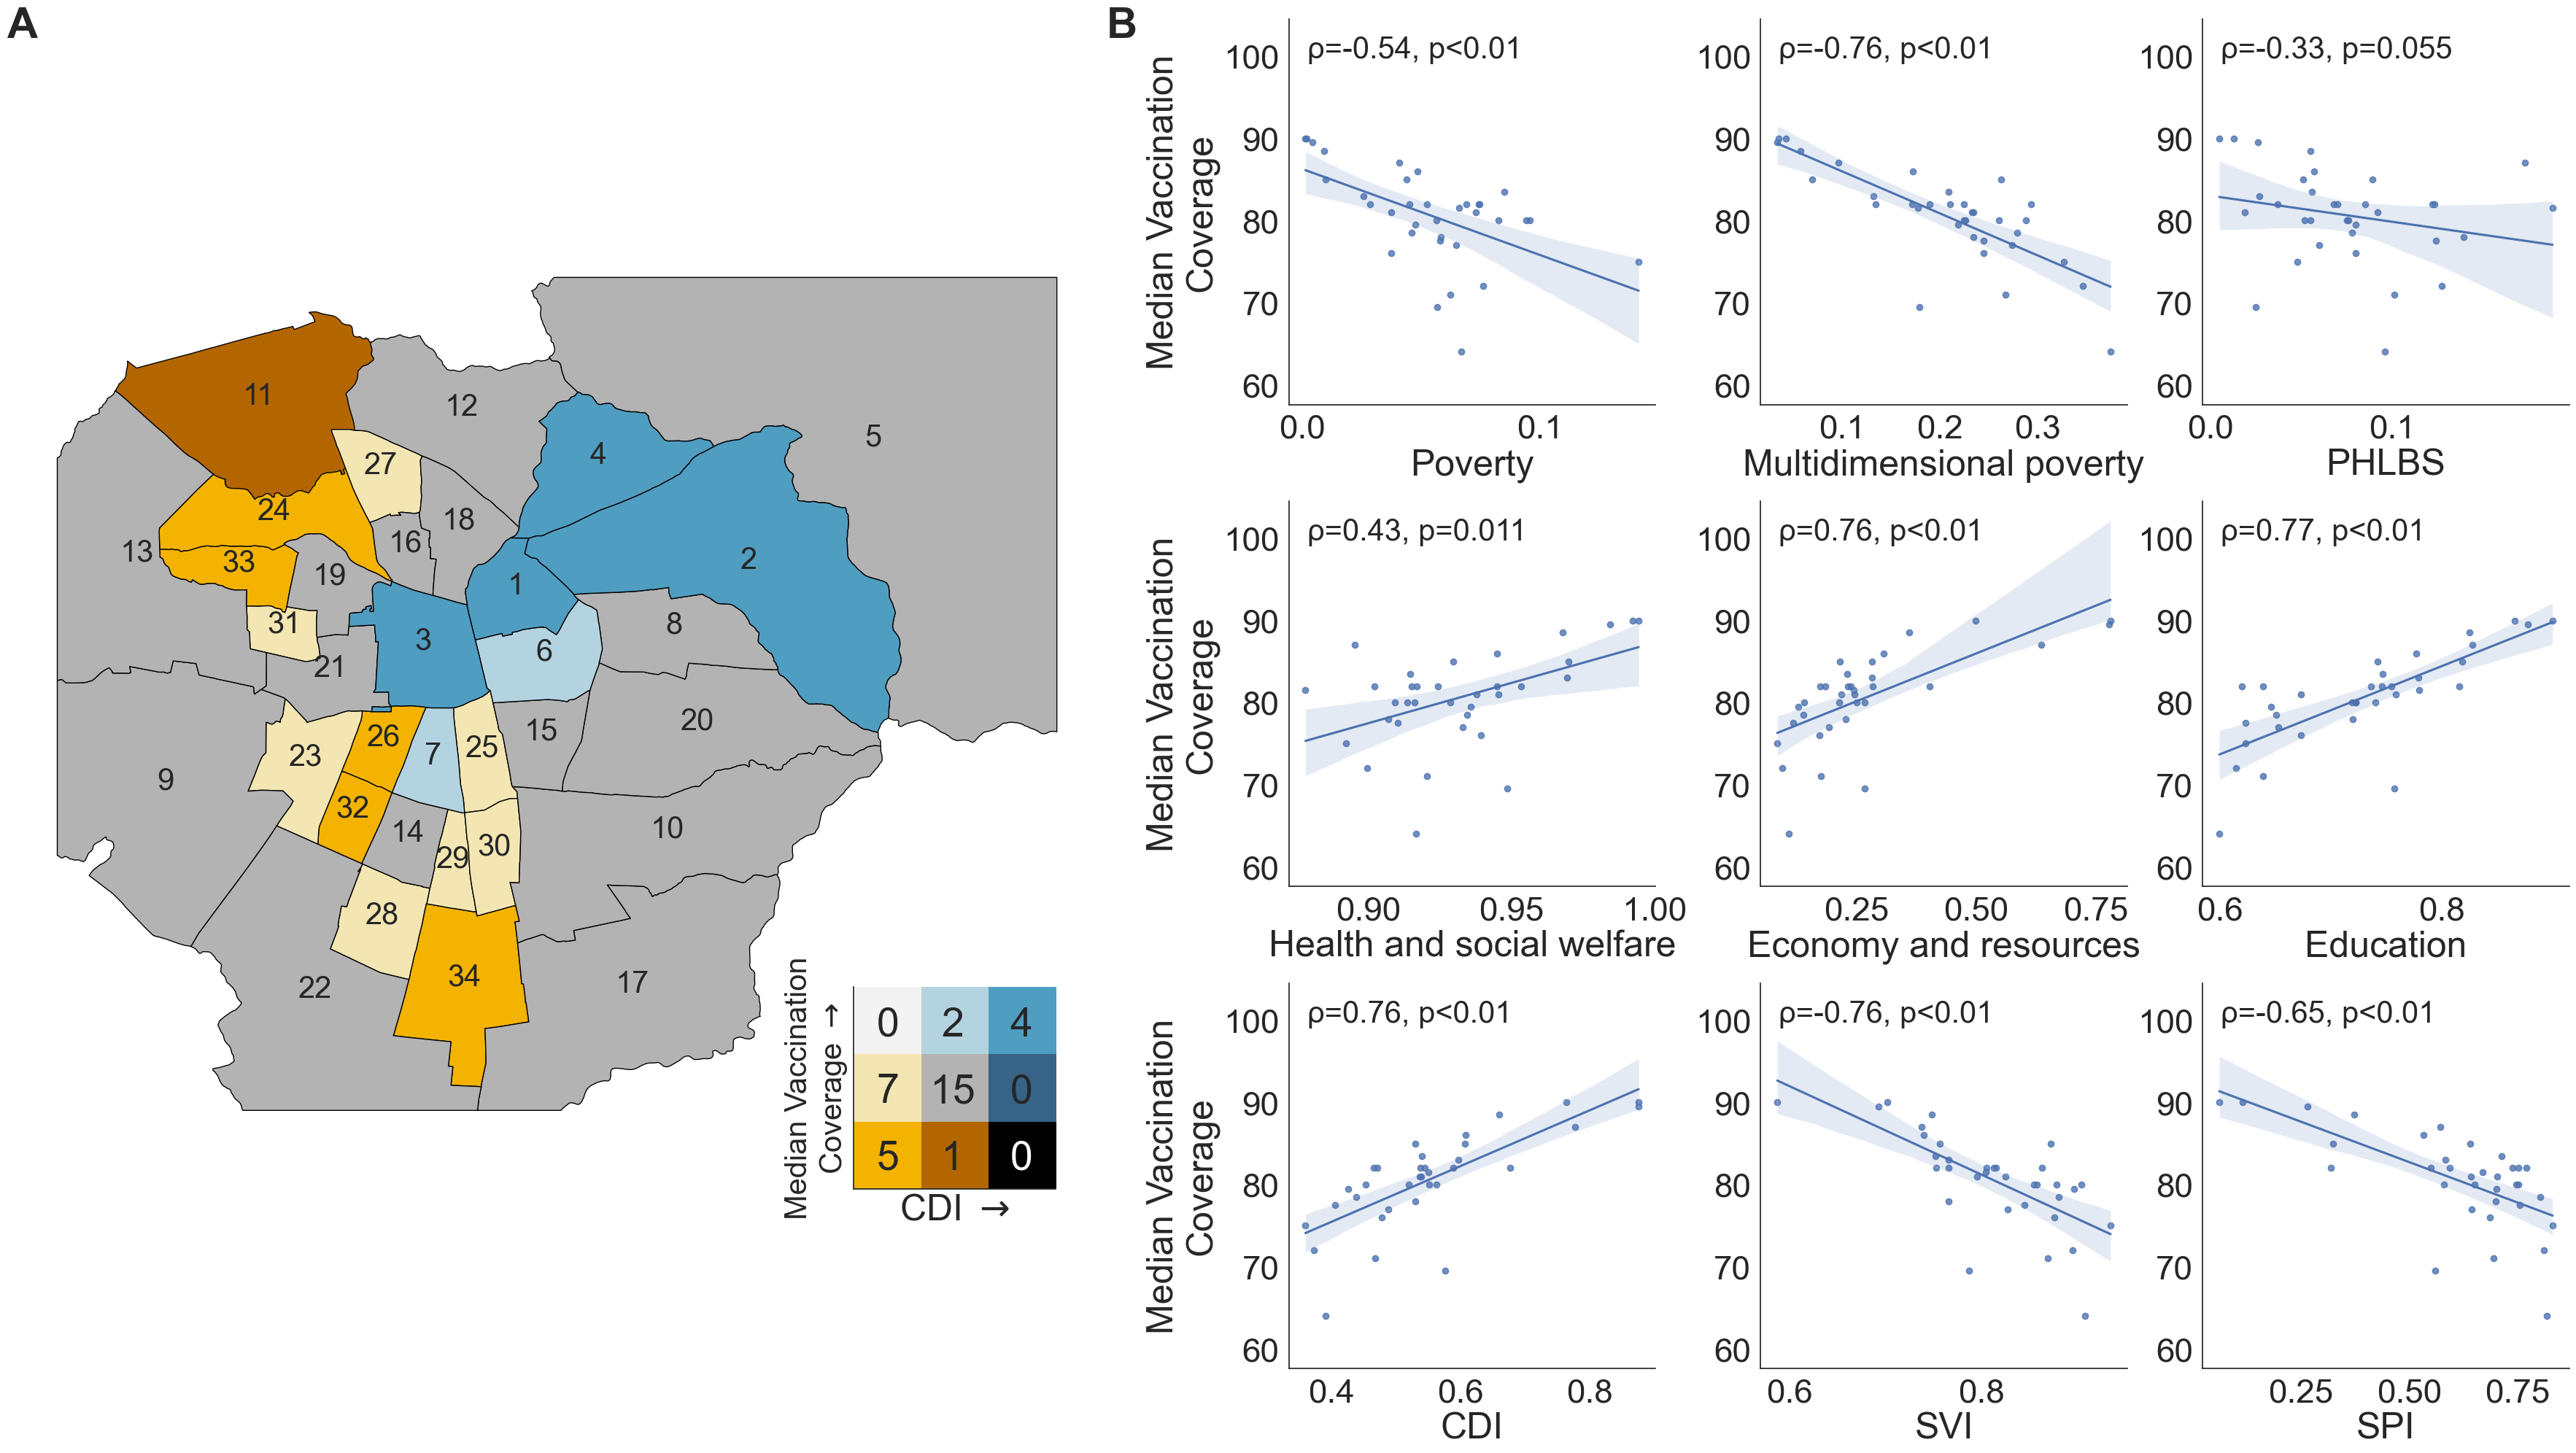

In [21]:
sns.set(style="white", font_scale=3)
fig, ax = plt.subplot_mosaic("AAABCD;AAAEFG;AAAHIJ", figsize=(16*2.2, 9*2.2), constrained_layout=True)
# ahora hacemos iteraciones anidadas, porque queremos las combinaciones de dos categorías
for j in range(n_categories):
    for i in range(n_categories):
        # buscamos las áreas que tienen ambos valores de categoría
        # areas_in_this_category = set(np.where(poverty_bin.yb == j)[0]) & set(np.where(porc_vacu_bin.yb == i)[0])
        areas_in_this_category = gstgo2.loc[(gstgo2.vac_lab == j) & (gstgo2.CDI_lab == i)].index.get_level_values('cod_comuna')
        gstgo2.loc[gstgo2.index.get_level_values('cod_comuna').isin(areas_in_this_category)].plot(color=bivariate_palette[(j, i)], ax=ax['A'], edgecolor='black')
        # gstgo2.iloc[list(areas_in_this_category)].plot(color=bivariate_palette[(j, i)], ax=ax['A'], edgecolor='black')
        to_legend[(j,i)] = areas_in_this_category
ax['A'].set_axis_off()
#print(ax['A'].get_xlim())
#ax['A'].set_xlim(-7888252.485875, -7834405.018025)
#ax['A'].set_ylim(-3981105.3905450013, -3933307.188555)
#ax.add_artist(ScaleBar(1, location='lower left', border_pad=3))

# dibujamos la leyenda. el parámetro de axes es la posición (x, y) y el ancho (width, height) de la leyenda.
a = fig.add_axes([.32, .18, .1, .14], facecolor='y')
a.imshow(cmap_xy, origin='lower')

a.set_xlabel(f'{ix} $\\rightarrow$', fontsize='medium')
a.set_ylabel('Median Vaccination\nCoverage $\\rightarrow$', fontsize='small')
a.set_xticks([])
a.set_yticks([])
sns.despine(ax=a)
# Show number in cmap
a.text(0.17, 0.15, len(to_legend[(0,0)]), transform=a.transAxes, fontsize=40, ha='center', va='center')
a.text(0.49, 0.15, len(to_legend[(0,1)]), transform=a.transAxes, fontsize=40, ha='center', va='center')
a.text(0.83, 0.15, len(to_legend[(0,2)]), transform=a.transAxes, fontsize=40, ha='center', va='center', color='w')
a.text(0.17, 0.48, len(to_legend[(1,0)]), transform=a.transAxes, fontsize=40, ha='center', va='center')
a.text(0.49, 0.48, len(to_legend[(1,1)]), transform=a.transAxes, fontsize=40, ha='center', va='center')
a.text(0.83, 0.48, len(to_legend[(1,2)]), transform=a.transAxes, fontsize=40, ha='center', va='center')
a.text(0.17, 0.81, len(to_legend[(2,0)]), transform=a.transAxes, fontsize=40, ha='center', va='center')
a.text(0.49, 0.81, len(to_legend[(2,1)]), transform=a.transAxes, fontsize=40, ha='center', va='center')
a.text(0.83, 0.81, len(to_legend[(2,2)]), transform=a.transAxes, fontsize=40, ha='center', va='center')

gstgo2.apply(lambda x: ax['A'].annotate(text=int(x['cdirank']), xy=x.geometry.centroid.coords[0], ha='center', fontsize='small'), axis=1);
#Annote W
for x in to_legend[(0,2)]:
    ax['A'].annotate(text=int(gstgo2.query(f"cod_comuna == {x}")['cdirank']), xy=gstgo2.loc[gstgo2.index.get_level_values('cod_comuna') == x].geometry.centroid.to_list()[0].coords[0], ha='center', fontsize='small', color='w');
#ax['A'].annotate(text=4, xy=gstgo2.loc[gstgo2['cdirank'] == 4].geometry.centroid.to_list()[0].coords[0], ha='center', fontsize='small', color='w');
#gstgo2.apply(lambda x: ax['A'].annotate(text=x['CDI'], xy=x.geometry.centroid.coords[0], ha='center', fontsize='small'), axis=1);

dicxlim = {
'Poverty': (-0.005705000000000001, 0.148405),
'Multidimensional poverty': (0.016739999999999994, 0.39206),
'PHLBS': (-0.00415, 0.19715),
'Health and social welfare': (0.872275, 1.0004250000000001),
'Economy and resources': (0.049409999999999996, 0.81479),
'Education': (0.584465, 0.915235),
'CDI': (0.33464, 0.90136),
'SVI': (0.57023710745, 0.95134432955),
'SPI': (0.024215, 0.868685),
}


ALPHA = 0.05
bbox = dict(boxstyle="round", fc="1", alpha=0.5)
size = "small"
        
idcs = ['Municipality', 'Province', 'Region', 'Macroregion', 'Poverty', 'Multidimensional poverty', 'PHLBS', 'Health and social welfare', 'Economy and resources', 'Education', 'CDI', 'SVI', 'SPI']
ses = idcs[4:]
lses = 'BCDEFGHIJ'
pv = 0.01
#test = pd.melt(grupMetropolitanal.reset_index(), id_vars=['Municipality', 'porc_vacu'], value_vars=idcs[4:], ignore_index = False)
for l, s in zip(lses,ses):
    r, p = stats.spearmanr(T[s], T['porc_vacu'])
    sns.regplot(x=s, y='porc_vacu', data=T, ax=ax[l], x_jitter=0, y_jitter=0)
    ax[l].set_ylim(grupMetropolitanal.porc_vacu.min()*0.9, grupMetropolitanal.porc_vacu.max()*1.1)
    # ax[l].set_ylim(61, 109)
    if s in ['Poverty', 'Health and social welfare', 'CDI']:
        ax[l].set_ylabel('Median Vaccination\nCoverage')
    else:
        ax[l].set_ylabel(None)
    if p < pv:
        ax[l].annotate(f'ρ={r:.2f}, p<{pv}',
                    xy=(.05, .90), xycoords=ax[l].transAxes, bbox=bbox, fontsize=size)
    else:
        ax[l].annotate(f'ρ={r:.2f}, p={p:.2g}',
                    xy=(.05, .90), xycoords=ax[l].transAxes, bbox=bbox, fontsize=size)
    ax[l].set_xlim(dicxlim[s])
    sns.despine(ax=ax[l])

ax['A'].text(0, 1.25, 'A', transform=ax['A'].transAxes,
        fontsize=42, fontweight='bold', va='top')
ax['A'].text(1, 1.25, 'B', transform=ax['A'].transAxes,
        fontsize=42, fontweight='bold', va='top')
#plt.tight_layout()
#plt.savefig(f'outputs/{fecha}/Figure_2_Santiago_Province_AB.pdf', dpi=300, bbox_inches='tight')


#### Figure 2 C-D

/Users/enzo/miniforge3/lib/python3.9/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/Users/enzo/miniforge3/lib/python3.9/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/Users/enzo/miniforge3/lib/python3.9/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/Users/enzo/miniforge3/lib/python3.9/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


Text(1, 1.25, 'D')

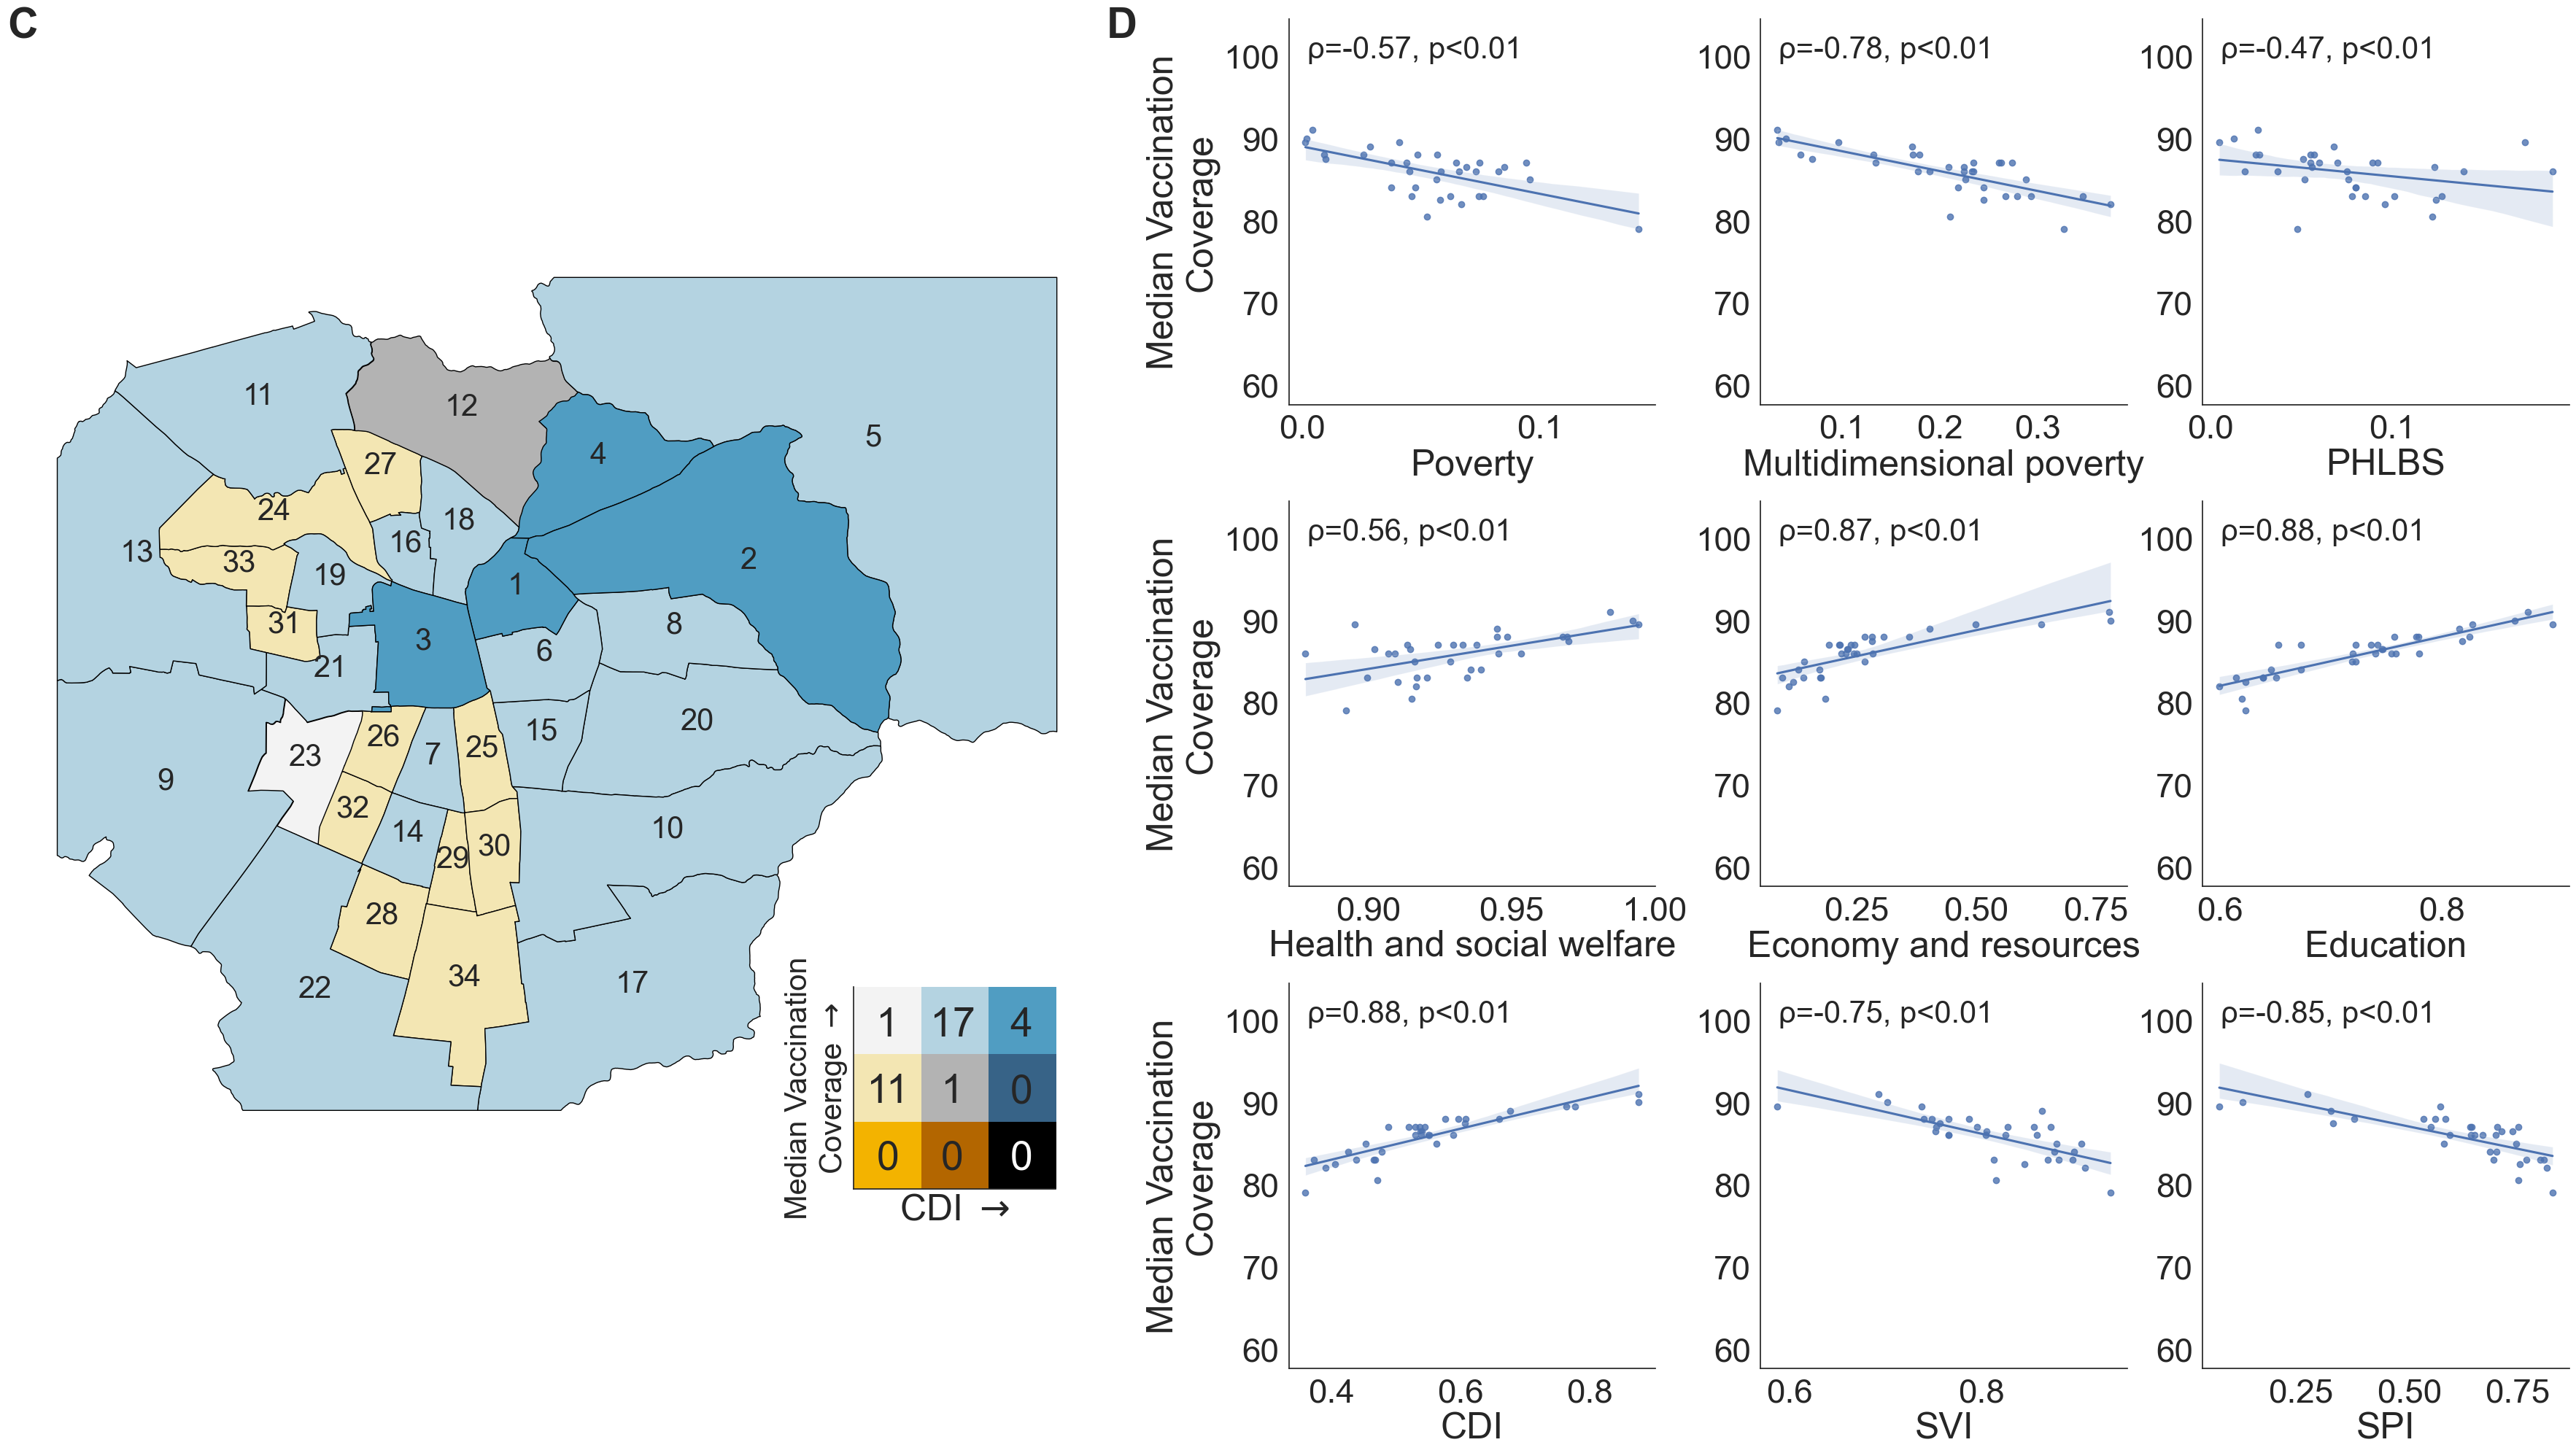

In [22]:
T = tipo['sub']
T = pd.merge(T, cod_rank[['cod_comuna', 'cdirank']], left_on = 'cod_comuna', right_on = 'cod_comuna', how = 'left')
import shapely

import geopandas as gpd
from splot.mapping import vba_choropleth
import matplotlib.pyplot as plt
%matplotlib inline
stgo = gpd.read_file('inputs/Comunas/comunas.shp')

def clip_area_geodataframe(geodf, bounding_box, buffer=0):
    # bounding box should be in same crs

    bounds = shapely.geometry.box(*bounding_box).buffer(buffer)

    try:
        result = geodf.assign(
            geometry=lambda g: g.map(lambda x: x.intersection(bounds))
        ).pipe(lambda x: x[x.geometry.area > 0])
    except Exception:
        # sometimes there are ill-defined intersections in polygons.
        result = geodf.assign(
            geometry=lambda g: g.buffer(0).map(lambda x: x.intersection(bounds))
        ).pipe(lambda x: x[x.geometry.area > 0])

    return result.set_crs(geodf.crs)
stgo = stgo.set_index(['Region', 'Provincia', 'Comuna', 'cod_comuna']).join(T.set_index(['cod_comuna'])).dropna()

gstgo2 = clip_area_geodataframe(stgo, bbox2)
import seaborn as sns
from scipy import stats
#fig, ax = plt.subplots(1, 2, figsize=(16, 9))
sns.set(style="white", font_scale=3)

fig, ax = plt.subplot_mosaic("AAABCD;AAAEFG;AAAHIJ", figsize=(16*2.2, 9*2.2), constrained_layout=True)
# ahora hacemos iteraciones anidadas, porque queremos las combinaciones de dos categorías
for j in range(n_categories):
    for i in range(n_categories):
        # buscamos las áreas que tienen ambos valores de categoría
        # areas_in_this_category = set(np.where(poverty_bin.yb == j)[0]) & set(np.where(porc_vacu_bin.yb == i)[0])
        areas_in_this_category = gstgo2.loc[(gstgo2.vac_lab == j) & (gstgo2.CDI_lab == i)].index.get_level_values('cod_comuna')
        gstgo2.loc[gstgo2.index.get_level_values('cod_comuna').isin(areas_in_this_category)].plot(color=bivariate_palette[(j, i)], ax=ax['A'], edgecolor='black')
        # gstgo2.iloc[list(areas_in_this_category)].plot(color=bivariate_palette[(j, i)], ax=ax['A'], edgecolor='black')
        to_legend[(j,i)] = areas_in_this_category
ax['A'].set_axis_off()
#print(ax['A'].get_xlim())
#ax['A'].set_xlim(-7888252.485875, -7834405.018025)
#ax['A'].set_ylim(-3981105.3905450013, -3933307.188555)
#ax.add_artist(ScaleBar(1, location='lower left', border_pad=3))

# dibujamos la leyenda. el parámetro de axes es la posición (x, y) y el ancho (width, height) de la leyenda.
a = fig.add_axes([.32, .18, .1, .14], facecolor='y')
a.imshow(cmap_xy, origin='lower')

a.set_xlabel(f'{ix} $\\rightarrow$', fontsize='medium')
a.set_ylabel('Median Vaccination\nCoverage $\\rightarrow$', fontsize='small')
a.set_xticks([])
a.set_yticks([])
sns.despine(ax=a)
# Show number in cmap
a.text(0.17, 0.15, len(to_legend[(0,0)]), transform=a.transAxes, fontsize=40, ha='center', va='center')
a.text(0.49, 0.15, len(to_legend[(0,1)]), transform=a.transAxes, fontsize=40, ha='center', va='center')
a.text(0.83, 0.15, len(to_legend[(0,2)]), transform=a.transAxes, fontsize=40, ha='center', va='center', color='w')
a.text(0.17, 0.48, len(to_legend[(1,0)]), transform=a.transAxes, fontsize=40, ha='center', va='center')
a.text(0.49, 0.48, len(to_legend[(1,1)]), transform=a.transAxes, fontsize=40, ha='center', va='center')
a.text(0.83, 0.48, len(to_legend[(1,2)]), transform=a.transAxes, fontsize=40, ha='center', va='center')
a.text(0.17, 0.81, len(to_legend[(2,0)]), transform=a.transAxes, fontsize=40, ha='center', va='center')
a.text(0.49, 0.81, len(to_legend[(2,1)]), transform=a.transAxes, fontsize=40, ha='center', va='center')
a.text(0.83, 0.81, len(to_legend[(2,2)]), transform=a.transAxes, fontsize=40, ha='center', va='center')

gstgo2.apply(lambda x: ax['A'].annotate(text=int(x['cdirank']), xy=x.geometry.centroid.coords[0], ha='center', fontsize='small'), axis=1);
#Annote W
for x in to_legend[(0,2)]:
    ax['A'].annotate(text=int(gstgo2.query(f"cod_comuna == {x}")['cdirank']), xy=gstgo2.loc[gstgo2.index.get_level_values('cod_comuna') == x].geometry.centroid.to_list()[0].coords[0], ha='center', fontsize='small', color='w');

#ax['A'].annotate(text=4, xy=gstgo2.loc[gstgo2['cdirank'] == 4].geometry.centroid.to_list()[0].coords[0], ha='center', fontsize='small', color='w');
#gstgo2.apply(lambda x: ax['A'].annotate(text=x['CDI'], xy=x.geometry.centroid.coords[0], ha='center', fontsize='small'), axis=1);

dicxlim = {
'Poverty': (-0.005705000000000001, 0.148405),
'Multidimensional poverty': (0.016739999999999994, 0.39206),
'PHLBS': (-0.00415, 0.19715),
'Health and social welfare': (0.872275, 1.0004250000000001),
'Economy and resources': (0.049409999999999996, 0.81479),
'Education': (0.584465, 0.915235),
'CDI': (0.33464, 0.90136),
'SVI': (0.57023710745, 0.95134432955),
'SPI': (0.024215, 0.868685),
}


ALPHA = 0.05
bbox = dict(boxstyle="round", fc="1", alpha=0.5)
size = "small"
        
idcs = ['Municipality', 'Province', 'Region', 'Macroregion', 'Poverty', 'Multidimensional poverty', 'PHLBS', 'Health and social welfare', 'Economy and resources', 'Education', 'CDI', 'SVI', 'SPI']
ses = idcs[4:]
lses = 'BCDEFGHIJ'
pv = 0.01
#test = pd.melt(grupMetropolitanal.reset_index(), id_vars=['Municipality', 'porc_vacu'], value_vars=idcs[4:], ignore_index = False)
for l, s in zip(lses,ses):
    r, p = stats.spearmanr(T[s], T['porc_vacu'])
    sns.regplot(x=s, y='porc_vacu', data=T, ax=ax[l], x_jitter=0, y_jitter=0)
    ax[l].set_ylim(grupMetropolitanal.porc_vacu.min()*0.9, grupMetropolitanal.porc_vacu.max()*1.1)
    # ax[l].set_ylim(61, 109)
    if s in ['Poverty', 'Health and social welfare', 'CDI']:
        ax[l].set_ylabel('Median Vaccination\nCoverage')
    else:
        ax[l].set_ylabel(None)
    if p < pv:
        ax[l].annotate(f'ρ={r:.2f}, p<{pv}',
                    xy=(.05, .90), xycoords=ax[l].transAxes, bbox=bbox, fontsize=size)
    else:
        ax[l].annotate(f'ρ={r:.2f}, p={p:.2g}',
                    xy=(.05, .90), xycoords=ax[l].transAxes, bbox=bbox, fontsize=size)
    ax[l].set_xlim(dicxlim[s])
    sns.despine(ax=ax[l])

ax['A'].text(0, 1.25, 'C', transform=ax['A'].transAxes,
        fontsize=42, fontweight='bold', va='top')
ax['A'].text(1, 1.25, 'D', transform=ax['A'].transAxes,
        fontsize=42, fontweight='bold', va='top')
#plt.tight_layout()
#plt.savefig(f'outputs/{fecha}/Figure_2_Santiago_Province_CD.pdf', dpi=300, bbox_inches='tight')


#### Figure 2 E-F

/Users/enzo/miniforge3/lib/python3.9/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/Users/enzo/miniforge3/lib/python3.9/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/Users/enzo/miniforge3/lib/python3.9/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/Users/enzo/miniforge3/lib/python3.9/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/Users/enzo/miniforge3/lib/python3.9/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


Text(1, 1.25, 'F')

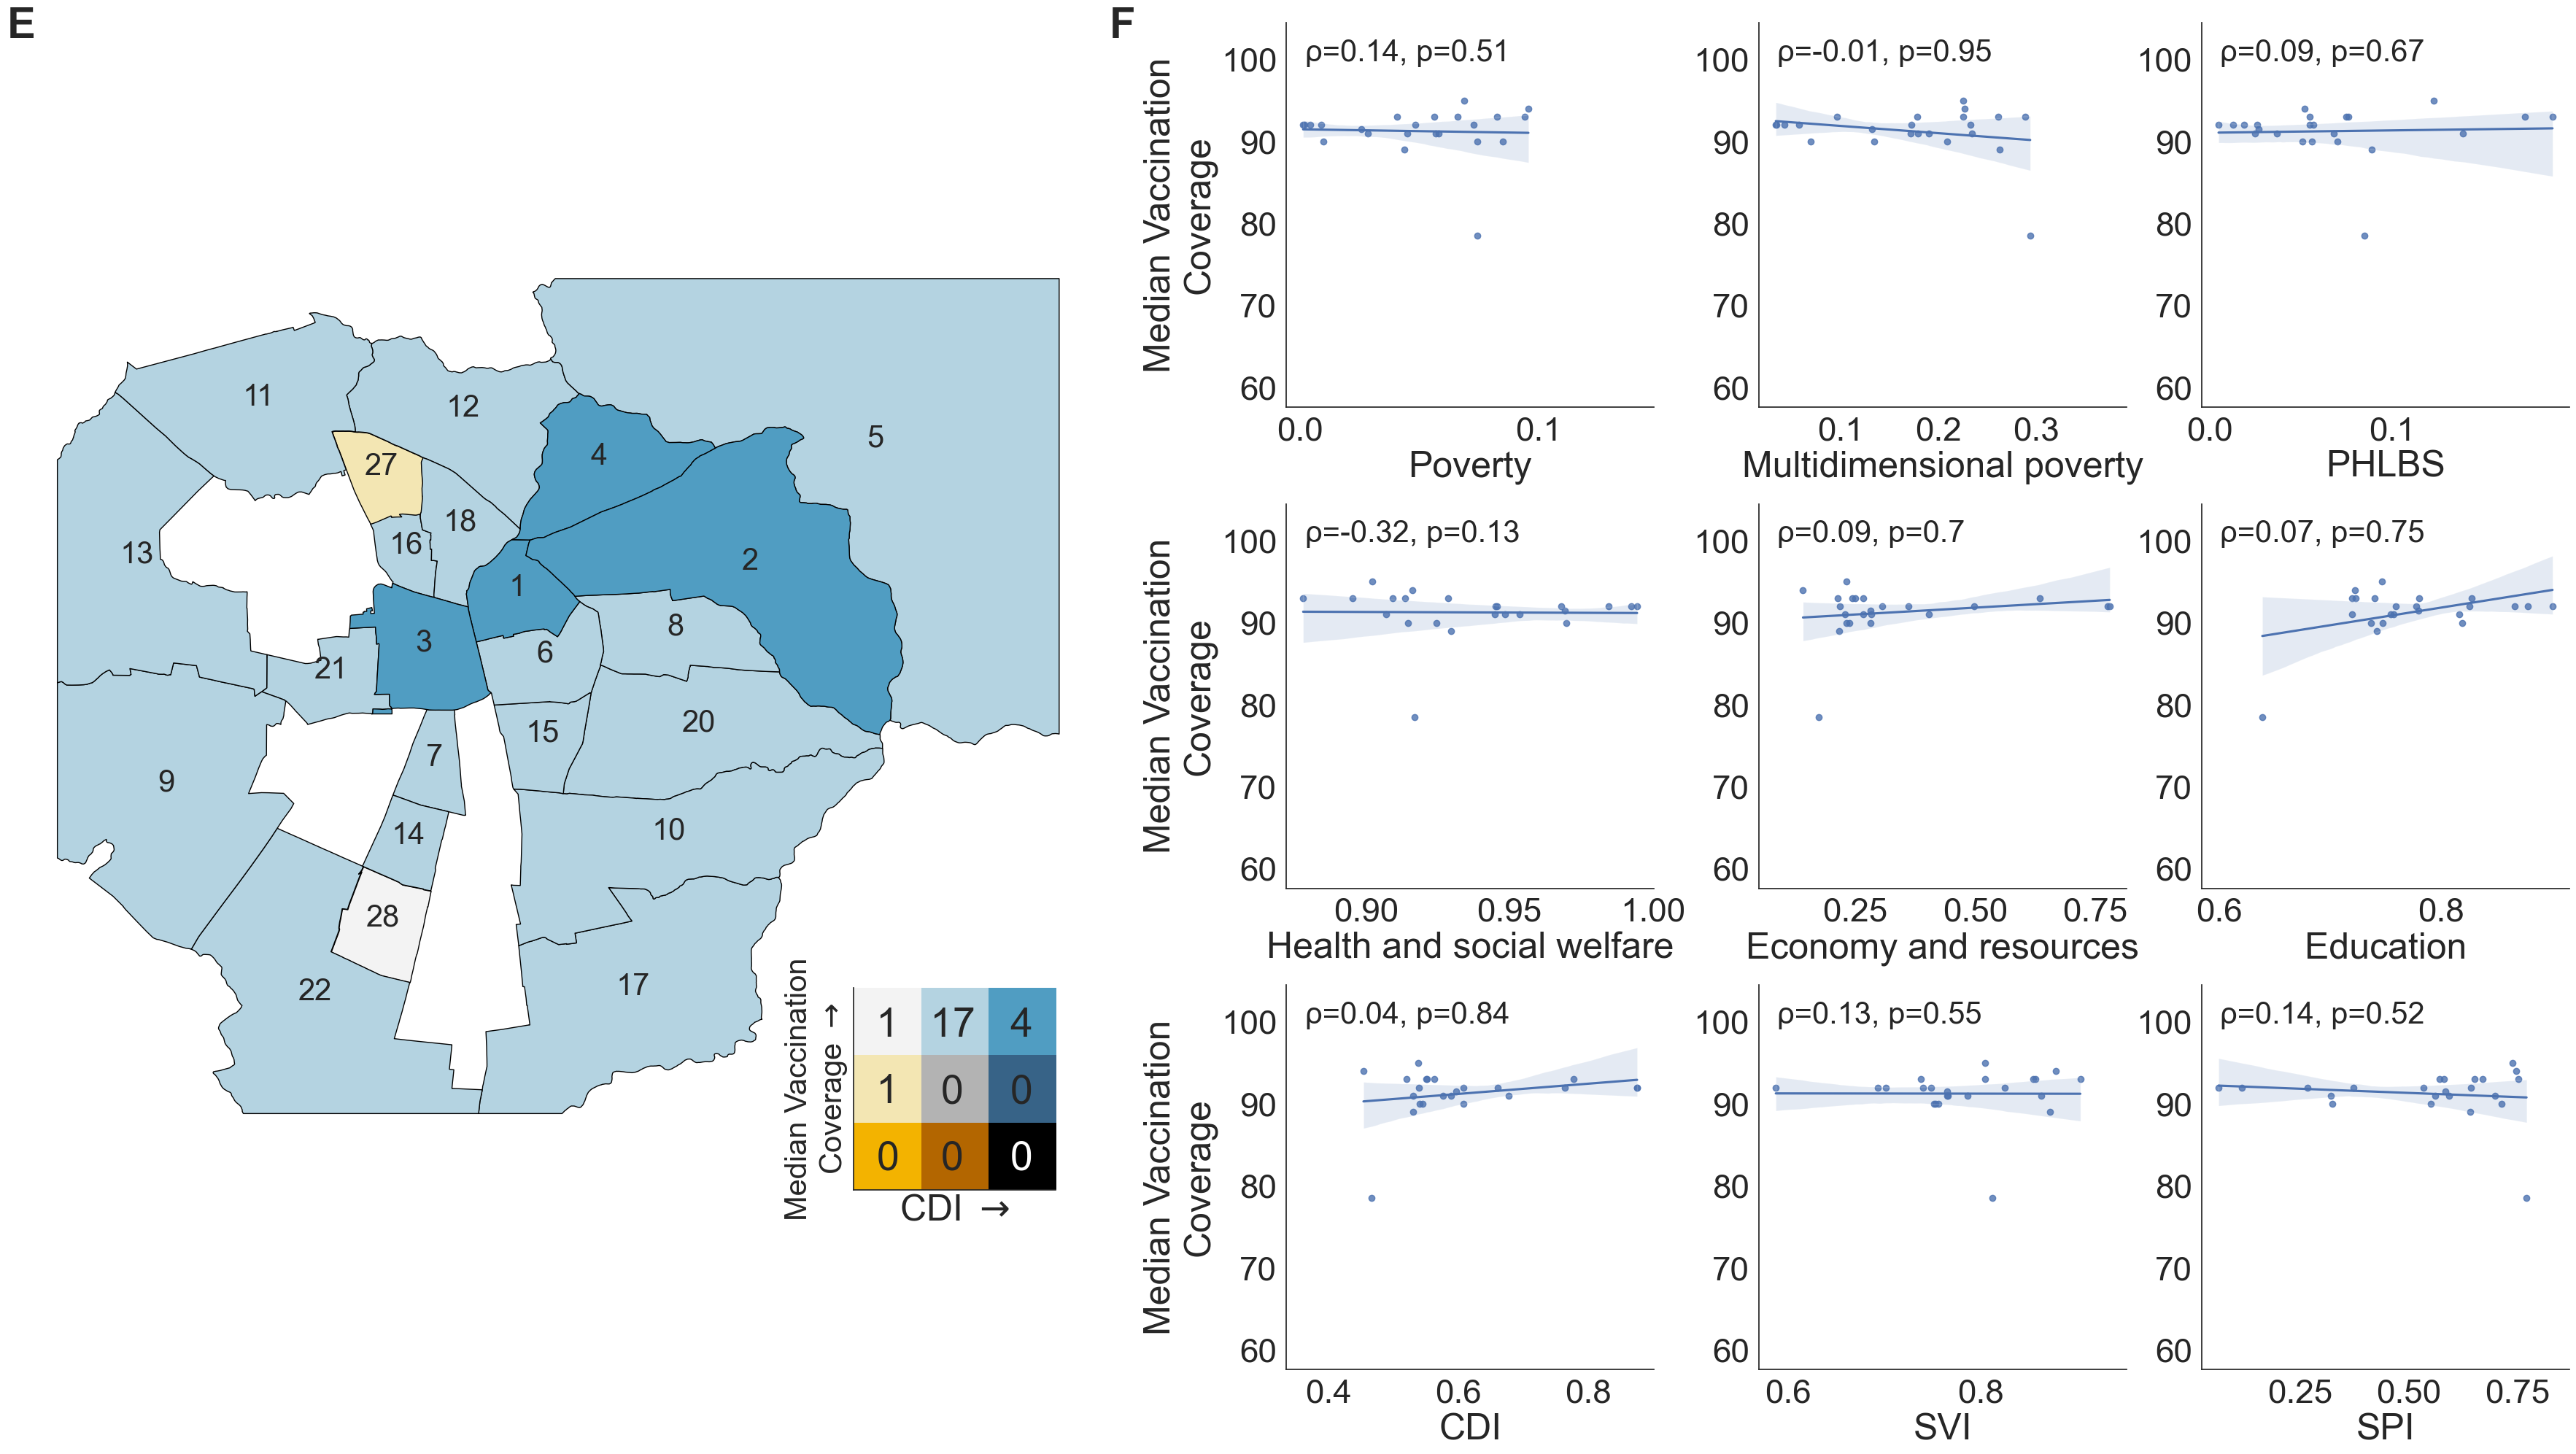

In [23]:
T = tipo['prib']
T = pd.merge(T, cod_rank[['cod_comuna', 'cdirank']], left_on = 'cod_comuna', right_on = 'cod_comuna', how = 'left')
import shapely

import geopandas as gpd
from splot.mapping import vba_choropleth
import matplotlib.pyplot as plt
%matplotlib inline
stgo = gpd.read_file('inputs/Comunas/comunas.shp')

def clip_area_geodataframe(geodf, bounding_box, buffer=0):
    # bounding box should be in same crs

    bounds = shapely.geometry.box(*bounding_box).buffer(buffer)

    try:
        result = geodf.assign(
            geometry=lambda g: g.map(lambda x: x.intersection(bounds))
        ).pipe(lambda x: x[x.geometry.area > 0])
    except Exception:
        # sometimes there are ill-defined intersections in polygons.
        result = geodf.assign(
            geometry=lambda g: g.buffer(0).map(lambda x: x.intersection(bounds))
        ).pipe(lambda x: x[x.geometry.area > 0])

    return result.set_crs(geodf.crs)
stgo = stgo.set_index(['Region', 'Provincia', 'Comuna', 'cod_comuna']).join(T.set_index(['cod_comuna'])).dropna()

gstgo2 = clip_area_geodataframe(stgo, bbox2)
import seaborn as sns
from scipy import stats
#fig, ax = plt.subplots(1, 2, figsize=(16, 9))
sns.set(style="white", font_scale=3)

fig, ax = plt.subplot_mosaic("AAABCD;AAAEFG;AAAHIJ", figsize=(16*2.2, 9*2.2), constrained_layout=True)
# ahora hacemos iteraciones anidadas, porque queremos las combinaciones de dos categorías
for j in range(n_categories):
    for i in range(n_categories):
        # buscamos las áreas que tienen ambos valores de categoría
        # areas_in_this_category = set(np.where(poverty_bin.yb == j)[0]) & set(np.where(porc_vacu_bin.yb == i)[0])
        areas_in_this_category = gstgo2.loc[(gstgo2.vac_lab == j) & (gstgo2.CDI_lab == i)].index.get_level_values('cod_comuna')
        gstgo2.loc[gstgo2.index.get_level_values('cod_comuna').isin(areas_in_this_category)].plot(color=bivariate_palette[(j, i)], ax=ax['A'], edgecolor='black')
        # gstgo2.iloc[list(areas_in_this_category)].plot(color=bivariate_palette[(j, i)], ax=ax['A'], edgecolor='black')
        to_legend[(j,i)] = areas_in_this_category
ax['A'].set_axis_off()
#print(ax['A'].get_xlim())
#ax['A'].set_xlim(-7888252.485875, -7834405.018025)
#ax['A'].set_ylim(-3981105.3905450013, -3933307.188555)
#ax.add_artist(ScaleBar(1, location='lower left', border_pad=3))

# dibujamos la leyenda. el parámetro de axes es la posición (x, y) y el ancho (width, height) de la leyenda.
a = fig.add_axes([.32, .18, .1, .14], facecolor='y')
a.imshow(cmap_xy, origin='lower')

a.set_xlabel(f'{ix} $\\rightarrow$', fontsize='medium')
a.set_ylabel('Median Vaccination\nCoverage $\\rightarrow$', fontsize='small')
a.set_xticks([])
a.set_yticks([])
sns.despine(ax=a)
# Show number in cmap
a.text(0.17, 0.15, len(to_legend[(0,0)]), transform=a.transAxes, fontsize=40, ha='center', va='center')
a.text(0.49, 0.15, len(to_legend[(0,1)]), transform=a.transAxes, fontsize=40, ha='center', va='center')
a.text(0.83, 0.15, len(to_legend[(0,2)]), transform=a.transAxes, fontsize=40, ha='center', va='center', color='w')
a.text(0.17, 0.48, len(to_legend[(1,0)]), transform=a.transAxes, fontsize=40, ha='center', va='center')
a.text(0.49, 0.48, len(to_legend[(1,1)]), transform=a.transAxes, fontsize=40, ha='center', va='center')
a.text(0.83, 0.48, len(to_legend[(1,2)]), transform=a.transAxes, fontsize=40, ha='center', va='center')
a.text(0.17, 0.81, len(to_legend[(2,0)]), transform=a.transAxes, fontsize=40, ha='center', va='center')
a.text(0.49, 0.81, len(to_legend[(2,1)]), transform=a.transAxes, fontsize=40, ha='center', va='center')
a.text(0.83, 0.81, len(to_legend[(2,2)]), transform=a.transAxes, fontsize=40, ha='center', va='center')

gstgo2.apply(lambda x: ax['A'].annotate(text=int(x['cdirank']), xy=x.geometry.centroid.coords[0], ha='center', fontsize='small'), axis=1);
#Annote W
for x in to_legend[(0,2)]:
    ax['A'].annotate(text=4, xy=gstgo2.loc[gstgo2.index.get_level_values('cod_comuna') == x].geometry.centroid.to_list()[0].coords[0], ha='center', fontsize='small', color='w');

#ax['A'].annotate(text=4, xy=gstgo2.loc[gstgo2['cdirank'] == 4].geometry.centroid.to_list()[0].coords[0], ha='center', fontsize='small', color='w');
#gstgo2.apply(lambda x: ax['A'].annotate(text=x['CDI'], xy=x.geometry.centroid.coords[0], ha='center', fontsize='small'), axis=1);

dicxlim = {
'Poverty': (-0.005705000000000001, 0.148405),
'Multidimensional poverty': (0.016739999999999994, 0.39206),
'PHLBS': (-0.00415, 0.19715),
'Health and social welfare': (0.872275, 1.0004250000000001),
'Economy and resources': (0.049409999999999996, 0.81479),
'Education': (0.584465, 0.915235),
'CDI': (0.33464, 0.90136),
'SVI': (0.57023710745, 0.95134432955),
'SPI': (0.024215, 0.868685),
}


ALPHA = 0.05
bbox = dict(boxstyle="round", fc="1", alpha=0.5)
size = "small"
        
idcs = ['Municipality', 'Province', 'Region', 'Macroregion', 'Poverty', 'Multidimensional poverty', 'PHLBS', 'Health and social welfare', 'Economy and resources', 'Education', 'CDI', 'SVI', 'SPI']
ses = idcs[4:]
lses = 'BCDEFGHIJ'
pv = 0.01
#test = pd.melt(grupMetropolitanal.reset_index(), id_vars=['Municipality', 'porc_vacu'], value_vars=idcs[4:], ignore_index = False)
for l, s in zip(lses,ses):
    r, p = stats.spearmanr(T[s], T['porc_vacu'])
    sns.regplot(x=s, y='porc_vacu', data=T, ax=ax[l], x_jitter=0, y_jitter=0)
    ax[l].set_ylim(grupMetropolitanal.porc_vacu.min()*0.9, grupMetropolitanal.porc_vacu.max()*1.1)
    # ax[l].set_ylim(61, 109)
    if s in ['Poverty', 'Health and social welfare', 'CDI']:
        ax[l].set_ylabel('Median Vaccination\nCoverage')
    else:
        ax[l].set_ylabel(None)
    if p < pv:
        ax[l].annotate(f'ρ={r:.2f}, p<{pv}',
                    xy=(.05, .90), xycoords=ax[l].transAxes, bbox=bbox, fontsize=size)
    else:
        ax[l].annotate(f'ρ={r:.2f}, p={p:.2g}',
                    xy=(.05, .90), xycoords=ax[l].transAxes, bbox=bbox, fontsize=size)
    ax[l].set_xlim(dicxlim[s])
    sns.despine(ax=ax[l])

ax['A'].text(0, 1.25, 'E', transform=ax['A'].transAxes,
        fontsize=42, fontweight='bold', va='top')
ax['A'].text(1, 1.25, 'F', transform=ax['A'].transAxes,
        fontsize=42, fontweight='bold', va='top')
#plt.tight_layout()
#plt.savefig(f'outputs/{fecha}/Figure_2_Santiago_Province_EF.pdf', dpi=300, bbox_inches='tight')
